In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math
import re
import warnings
import textwrap

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Read gene information
genes = r"path/genes.csv"
genes = pd.read_csv(genes)

# Read masks
msk = r"path/mask_def.tsv"
msk = pd.read_csv(msk, sep="\t", header=None)

# Read and prepare list of binary phenotypes
phen_b = r"path/pheno_bin.txt"
pheno_b = pd.read_csv(phen_b, header=None)
pheno_b[0] = pheno_b[0].str.rsplit('.',n=1).str.get(0)

# Read and prepare list of quantitative phenotypes
phen_q = r"/path/pheno_quantitative.txt"
pheno_q = pd.read_csv(phen_q, header=None)
pheno_q[0]=pheno_q[0].str.rsplit('.',n=1).str.get(0)


In [5]:
def fill_sig(pheno, sig, phen_type:str, j):
    """
    A function for preparing the content of the significant
    results dataframe.
    -------------------
    
    pheno pandas.DataFrame:
        The dataframe containing a list of our phenotypes.
    
    sig pandas.DataFrame:
        The existing significant results dataframe.
        
    pheno_type str:
        A string showing if the data is binary or quantitative (quan).
        
    j int:
        The chromosome number.
    -------------------
    
    returns sig with added rows.
    """
    
    for i in range(len(pheno)):
        # Get phenotype value        
        phen = pheno[0].values[i]

        # Read regenie output file for chromosome by chromosome and phenotype 
        rege = r"/path/"+phen_type+"/"+phen+"/step2_"+str(j)+"_"+phen+".regenie"
        reg = pd.read_csv(rege, sep=" ", skiprows=1)

        # Add phenotype column to the regenie output file      
        reg['pheno'] = phen
        reg['pheno_type'] = phen_type

        # Remove all summary rows and reset index
        reg = reg.dropna(subset=['ALLELE0'])
        reg = reg.reset_index()

        # Add snp info

        # Read snplist file
        snpl = r"/path/"+phen_type+"/"+phen+"/step2_"+str(j)+"_masks.snplist"
        snps = pd.read_csv(snpl, sep="\t", header=None)

        # Add info from file to regenie df (number of vars and start and end pos for each row)
        snps[1] = snps[1].str.split(',').apply(lambda x: [k for k in x])
        reg['num_var'] = snps[1].apply(len)
        reg['snp_start_pos'] = snps[1].apply(lambda x: x[0])
        reg['snp_end_pos'] = snps[1].apply(lambda x: x[-1])
        reg['LOG10P']=reg['LOG10P'].astype(float)
        
        # Add significant results (log10 p-val > cut-off) to the sig df    
        sig = pd.concat([sig, reg[reg['LOG10P']>5]])
        
        
    return sig
        

In [13]:
# Init significant output (sig) dataframe
sig = pd.DataFrame()

# Fill sig with information of significant regenie outputs for all chroms (binary pheno)
for chrom in range(16,17):
    # Get phenotype value
    sig = fill_sig(pheno_q, sig, 'quan', chrom)
    print(str(chrom)+" quan")
    sig = fill_sig(pheno_b, sig, 'binary', chrom)
    print(str(chrom)+" bin")
    
sig['CHROM'] = sig['CHROM'].astype(int)    
sig = fill_sig(pheno_b, sig, 'binary', 'X')
print(str(chrom)+" quan")
sig = fill_sig(pheno_q, sig, 'quan', 'X')
print(str(chrom)+" bin")

# Save the read significant variants without much additional info added
sig.to_csv("./path/sig_temp.tsv", index=False, sep='\t')

In [140]:
# This cell is for adding info to sig to use for plots

sig['CHROM']=sig['CHROM'].replace(23, 'X')

# Init columns
sig['mask']=''
sig['Al1']=''
sig['OR']=0
sig['upper']=0
sig['lower']=0
sig['MAF']=0
sig['ID2']=''
sig['cases']=0
sig['controls']=0

# Init column based values (sub strings)
ID = sig['ID'].str.rsplit('.',n=3).str.get(0)
mask = sig['ALLELE1'].str.rsplit('.',n=2).str.get(0)
maf = sig['ALLELE1'].str.split('.',n=1).str.get(1)

# Add the mask information to sig from the msk dataset
for i in range(len(sig)):
    if mask.iloc[i]=='Mask1':
        sig['mask'].iloc[i] = msk[1].iloc[0]
    elif mask.iloc[i]=='Mask2':
        sig['mask'].iloc[i] = msk[1].iloc[1]
    elif mask.iloc[i]=='Mask3':
        sig['mask'].iloc[i] = msk[1].iloc[2]
    elif mask.iloc[i]=='Mask4':
        sig['mask'].iloc[i] = msk[1].iloc[3]
    elif mask.iloc[i]=='Mask5':
        sig['mask'].iloc[i] = msk[1].iloc[4]
    
    # Fill other initialized columns   
    sig['OR'].iloc[i] = math.exp(sig['BETA'].iloc[i])
    sig['upper'].iloc[i] = math.exp(sig['BETA'].iloc[i]+(1.96*sig['SE'].iloc[i]))
    sig['lower'].iloc[i] = math.exp(sig['BETA'].iloc[i]-(1.96*sig['SE'].iloc[i]))
    sig['MAF'].iloc[i] = maf.iloc[i]
    sig['Al1'].iloc[i] = sig['mask'].iloc[i] + '_' + str(sig['MAF'].iloc[i])
    sig['ID2'].iloc[i] = ID.iloc[i]
    
    # Get regenie log url
    phe = sig['pheno'].iloc[i]
    if sig['CHROM'].iloc[i]!='X':
        chro = str(int(sig['CHROM'].iloc[i]))
    else:
        chro = str(sig['CHROM'].iloc[i])
    ty = sig['pheno_type'].iloc[i]
    log = "/path/"+ty+"/"+phe+"/step2_"+chro+".log"
    
    # Read log info and get the number of cases and controls if binary
    if ty =='binary':
        with open(log, 'rb') as f:
            contents = f.read().decode('utf-8')
            num_cases = int(re.search(r'(\d+) cases', contents).group(1))
            num_controls = int(re.search(r'(\d+) controls', contents).group(1))
    else:
        with open(log, 'rb') as f:
            contents = f.read().decode('utf-8')
            num_cases = int(re.search(r'(\d+) observations', contents).group(1))
            num_controls = ''
        
    sig['cases'].iloc[i] = num_cases
    sig['controls'].iloc[i] = num_controls


In [212]:
def nearest_genes(chrom, pos, genes, distance_le):
    """
    A function for finding the nearest gene to a given
    chromosome position.
    
    ---------------------
    chrom int or str:
        The chromosome number
    pos int:
        The position on the chromosome
    gene pandas.DataFrame:
        Reference dataset showing type and position of genes.
    distance_le int:
        Maximum the distance to search from our position.
    
    ---------------------
    filt.iloc[0] pandas.core.series.Series: 
        A pandas series containing the information of the 
        nearest gene.
    pos_st str:
        The start position for search.
    pos_en str:
        The end position for search.
        
    """
    pos_st = pos - distance_le
    pos_en = pos + distance_le

    filt = genes[genes['genetype']=="protein_coding"]
    filt=filt.dropna(subset=['hgncid'])
    filt = filt[filt['chrom']==str(chrom)]
    filt = filt[filt['pos_end']>=pos_st]
    filt = filt[filt['pos_start']<=pos_en]

    if(len(filt)==0):
        return None, str(pos_st), str(pos_en)
    
    filt['dist2gene'] = 0.0
    for j in range(len(filt)):
        if filt['pos_start'].iloc[j] >= pos:  
            filt['dist2gene'].iloc[j] = float(filt['pos_start'].iloc[j] - pos)
        elif filt['pos_end'].iloc[j] >= pos and filt['pos_start'].iloc[j] <= pos:
            filt['dist2gene'].iloc[j] = 0
        elif filt['pos_end'].iloc[j] <= pos:
            filt['dist2gene'].iloc[j] = float(pos - filt['pos_end'].iloc[j])    
    
    filt = filt.sort_values(by=['dist2gene'])
    return filt.iloc[0], str(pos_st), str(pos_en)


In [213]:
sig['pos_st']=''
sig['pos_en']=''
sig['ensembl_gene_id']='N/A'
sig['gene_name']='N/A'

for i in range(len(sig)):
    gene_f, sig['pos_st'].iloc[i], sig['pos_en'].iloc[i] = nearest_genes(sig['CHROM'].iloc[i], 
                                                                         sig['GENPOS'].iloc[i], 
                                                                         genes, 8e5)
    if (gene_f is not None):
        sig['ensembl_gene_id'].iloc[i] = gene_f['ensembl_gene_id']
        sig['gene_name'].iloc[i] = gene_f['gene_name']


In [146]:
# Save file to read later
sig.to_csv("./path/reg_result.tsv", index=False, sep='\t')

In [4]:
# To read the sig df if needed
sig = r"./path/reg_result.tsv"
sig = pd.read_csv(sig, sep="\t")

In [9]:
# To read the alternative sig df (made in regenie step2 prep jupyternotebook)
sig = r"/path/all_sigs.tsv"
sig = pd.read_csv(sig, sep="\t")

def conv(x):
    '''
    Function for fixing the type for chrom column
    '''
    try:
        return int(float(x))
    except ValueError:
        return x
    
sig['CHROM'] = sig['CHROM'].apply(conv)

In [18]:
# Number of log10p>5 associations
len(sig)

8122

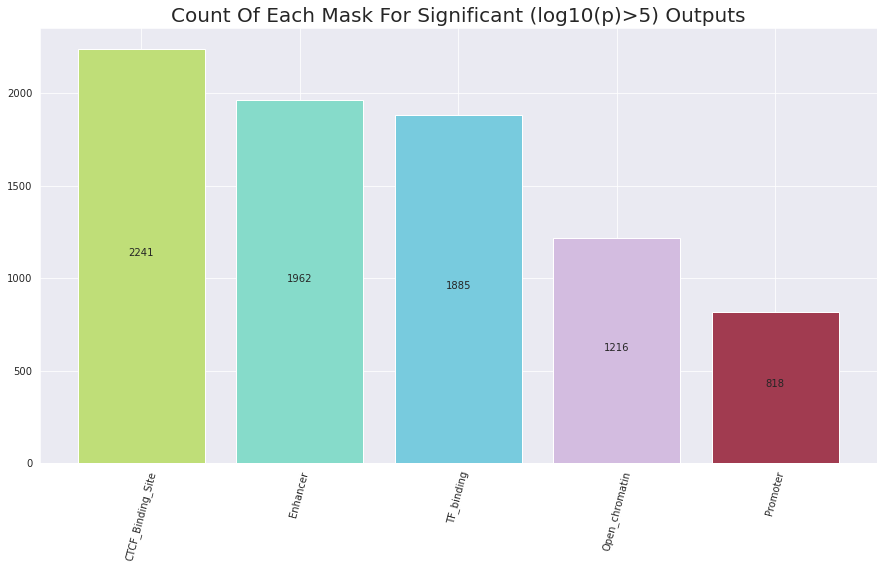

In [20]:
# Plot for count of mask for log10p>5

# prep data
mask_c = sig['mask'].value_counts()
mask_c = mask_c.to_frame().reset_index()
mask_c

# make plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1,figsize=(15, 8))
colors = ['#bfde78','#86dbca','#78cbde','#d3bce0','#a13b50','#661741']
plt.xticks(rotation=75)
ax.bar(x=[str(i) for i in mask_c['index'].values], height=mask_c['mask'].values,
       color=colors)

# write values on bar
vals = list(mask_c['mask'].values)
for i in range(len(mask_c)):
    plt.text(i, vals[i]/2, f"{vals[i]}", ha='center')

# add title and save
ax.set_title('Count Of Each Mask For Significant (log10(p)>5) Outputs', fontsize=20)
plt.savefig('.path/mask_sig5.png', format='png', bbox_inches='tight')

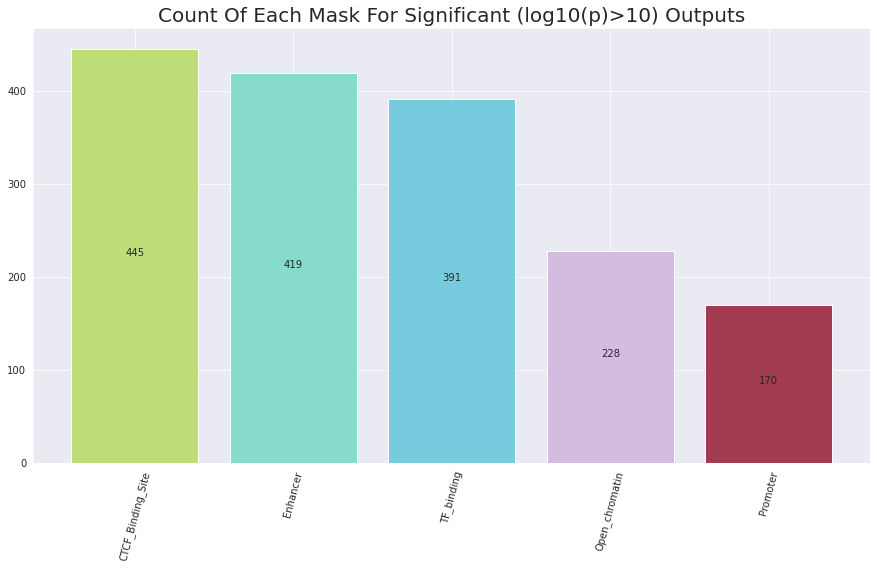

In [21]:
# Plot for count of mask for log10p>10

# prep data
mask_c = sig[sig['LOG10P']>10]['mask'].value_counts()
mask_c = mask_c.to_frame().reset_index()
mask_c

# make plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1,figsize=(15, 8))
colors = ['#bfde78','#86dbca','#78cbde','#d3bce0','#a13b50','#661741']
plt.xticks(rotation=75)
ax.bar(x=[str(i) for i in mask_c['index'].values], height=mask_c['mask'].values,
       color=colors)

# write values on bars
vals = list(mask_c['mask'].values)
for i in range(len(mask_c)):
    plt.text(i, vals[i]/2, f"{vals[i]}", ha='center')

# add title and save
ax.set_title('Count Of Each Mask For Significant (log10(p)>10) Outputs', fontsize=20)
plt.savefig('.path/mask_sig10.png', format='png', bbox_inches='tight')

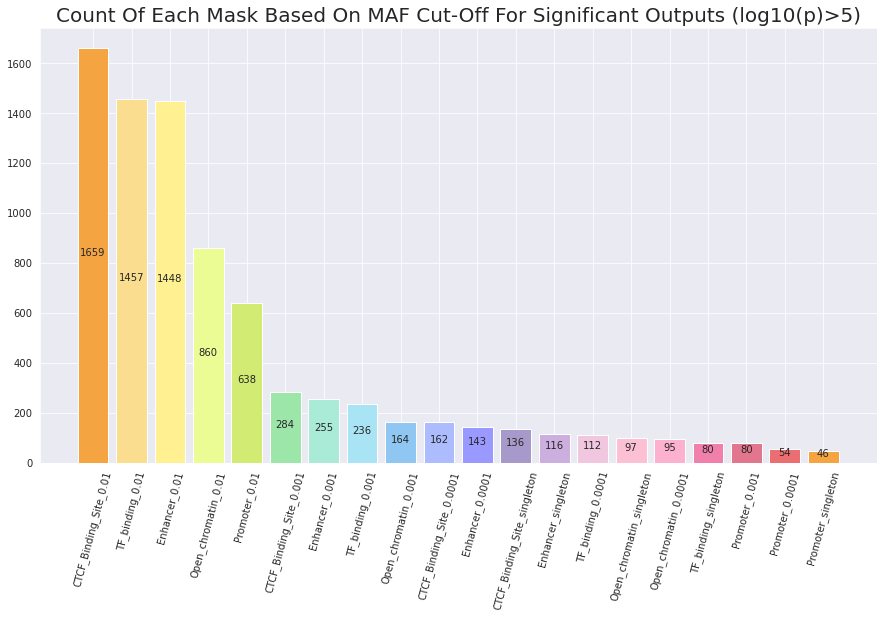

In [22]:
# Plot for count of mask for log10p>5 with MAF cut-off

# prep data
mask_c = sig['Al1'].value_counts()
mask_c = mask_c.to_frame().reset_index()
mask_c

# make plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1,figsize=(15, 8))
colors = ['#f5a442','#fadd8e','#fff091','#ebfc95','#d1eb73','#9ce6aa',
          '#a9ebd6','#a9e4f5','#8fc6f2','#adbcff','#9999ff','#a799c9',
          "#ccafde", "#f0c7df",'#fcc0d5','#fcb1ce','#f07fab','#e3768f', '#eb6e72']
plt.xticks(rotation=75)
ax.bar(x=[str(i) for i in mask_c['index'].values], height=mask_c['Al1'].values,
       color=colors)

# write values in bars
vals = list(mask_c['Al1'].values)
for i in range(len(mask_c)):
    plt.text(i, vals[i]/2, f"{vals[i]}", ha='center')

# set title and save
ax.set_title('Count Of Each Mask Based On MAF Cut-Off For Significant Outputs (log10(p)>5)', 
             fontsize=20)
plt.savefig('./path/mask_sig5_c.png', format='png', bbox_inches='tight')

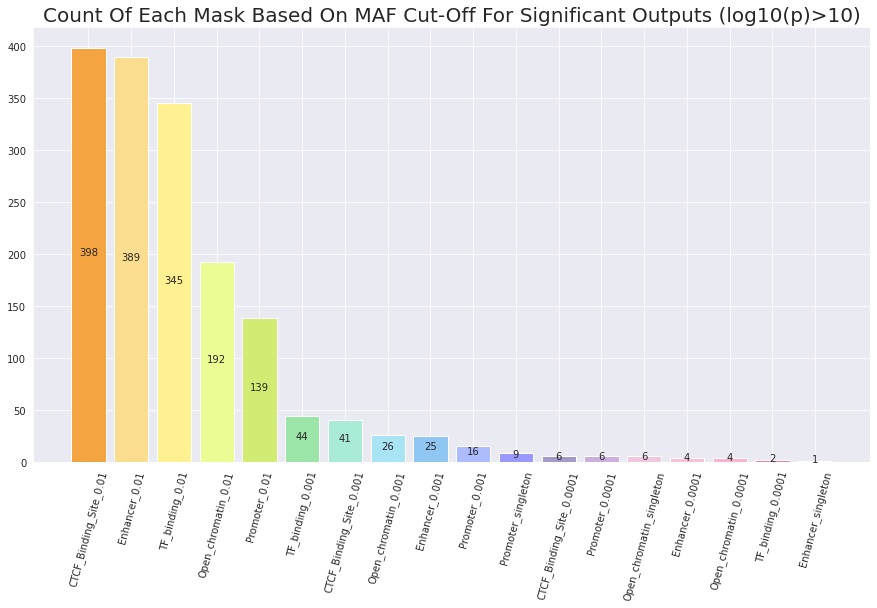

In [23]:
# Plot for count of mask for log10p>10 with MAF cut-off

# prep data
mask_c = sig[sig['LOG10P']>10]['Al1'].value_counts()
mask_c = mask_c.to_frame().reset_index()
mask_c

# plot data
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1,figsize=(15, 8))
colors = ['#f5a442','#fadd8e','#fff091','#ebfc95','#d1eb73','#9ce6aa',
          '#a9ebd6','#a9e4f5','#8fc6f2','#adbcff','#9999ff','#a799c9',
          "#ccafde", "#f0c7df",'#fcc0d5','#fcb1ce','#f07fab','#e3768f', '#eb6e72']
plt.xticks(rotation=75)
ax.bar(x=[str(i) for i in mask_c['index'].values], height=mask_c['Al1'].values,
       color=colors)

# write values in bars
vals = list(mask_c['Al1'].values)
for i in range(len(mask_c)):
    plt.text(i, vals[i]/2, f"{vals[i]}", ha='center')

# add title and save
ax.set_title('Count Of Each Mask Based On MAF Cut-Off For Significant Outputs (log10(p)>10)', 
             fontsize=20)
plt.savefig('./path/mask_sig10_c.png', format='png', bbox_inches='tight')

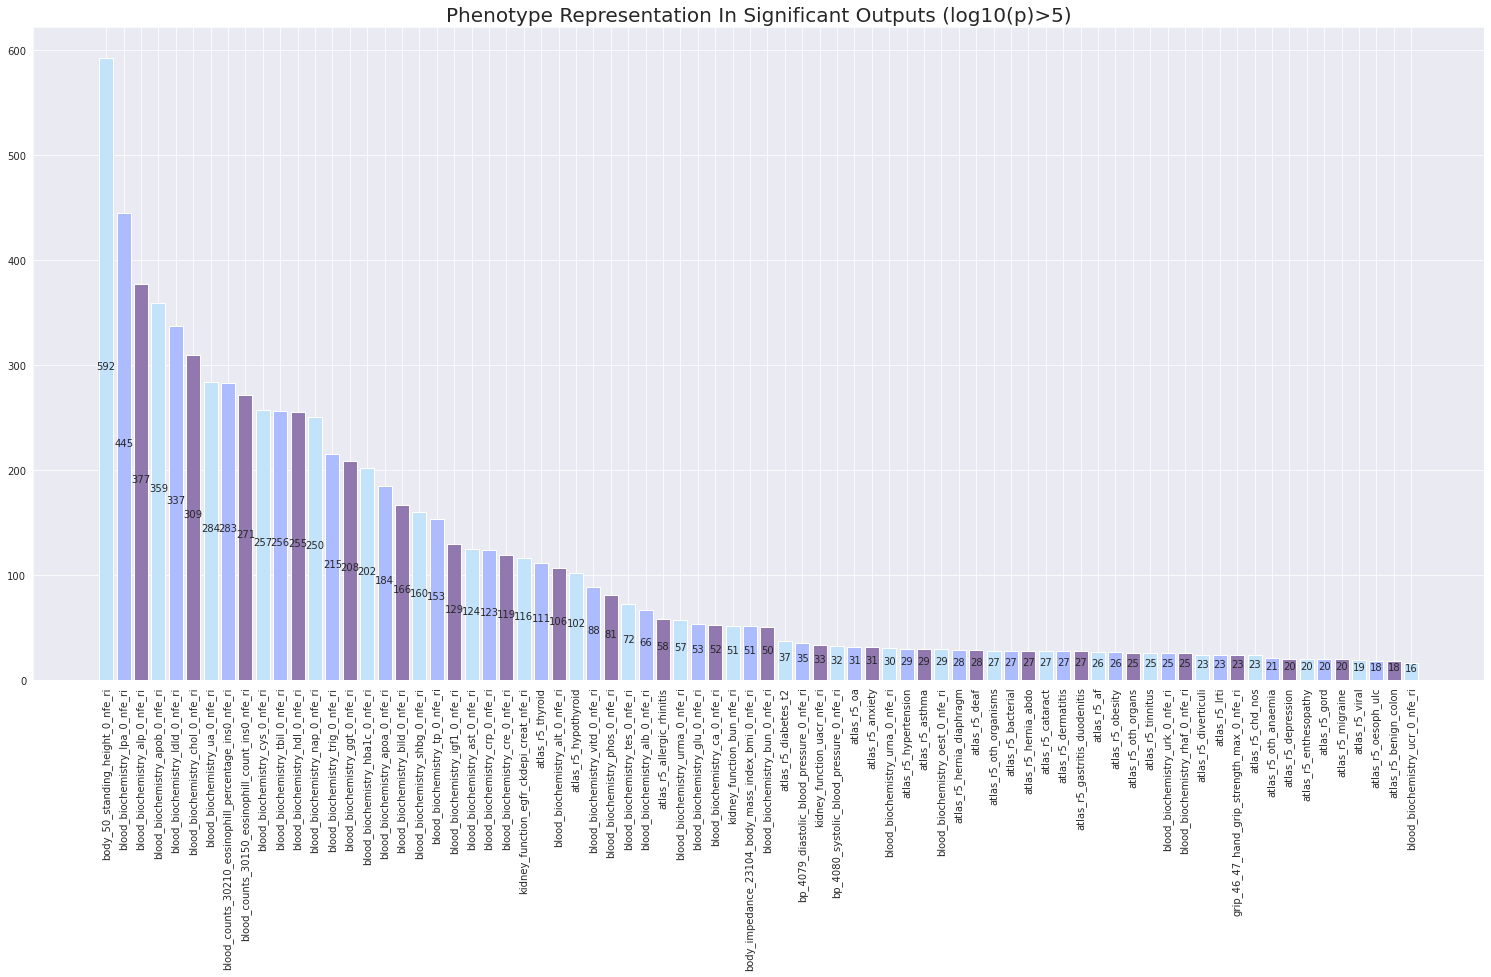

In [24]:
# Plot for count of phenotype for log10p>5

# prep data
pheno = sig['pheno'].value_counts()
pheno = pheno.to_frame().reset_index()

# make plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1,figsize=(26, 12))
colors = ['#c3e3fa','#adbcff','#9179b0']
plt.xticks(rotation=90)
ax.bar(x=[str(i) for i in pheno['index'].values], height=pheno['pheno'].values,
       color=colors)

# write values in bars
vals = list(pheno['pheno'].values)
for i in range(len(pheno)):
    plt.text(i, vals[i]/2, f"{vals[i]}", ha='center')

# add title and save
ax.set_title('Phenotype Representation In Significant Outputs (log10(p)>5)', fontsize=20)
plt.savefig('./path/pheno_sig5.png', format='png', bbox_inches='tight')

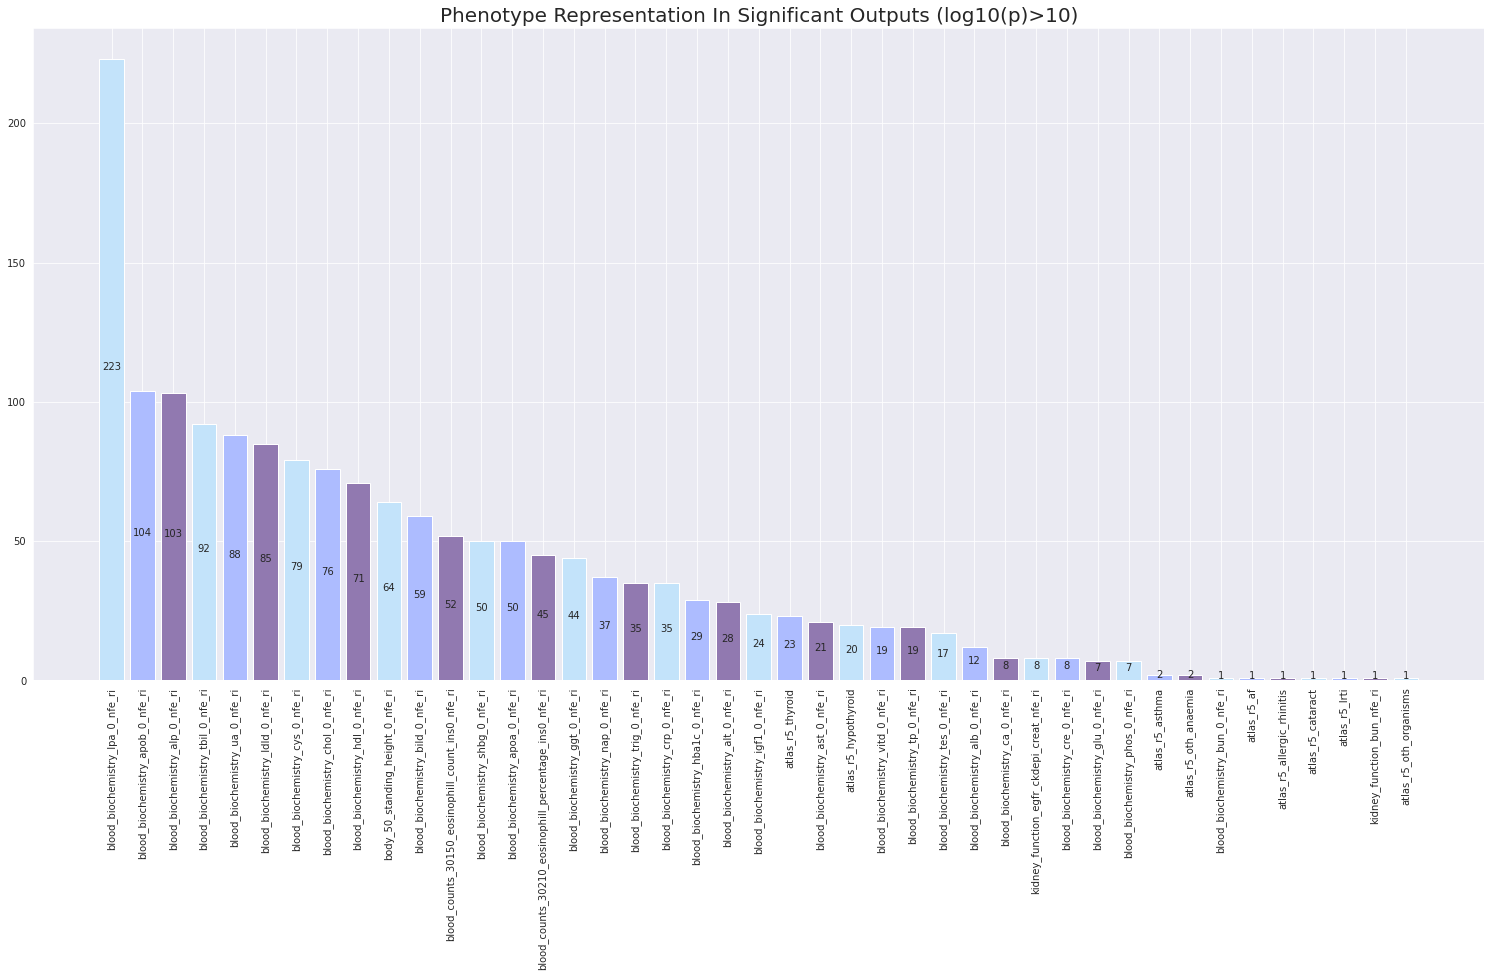

In [25]:
# Plot for count of phenotype for log10p>10

# prep data
pheno = sig[sig['LOG10P']>10]['pheno'].value_counts()
pheno = pheno.to_frame().reset_index()

# make plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1,figsize=(26, 12))
colors = ['#c3e3fa','#adbcff','#9179b0']
plt.xticks(rotation=90)
ax.bar(x=[str(i) for i in pheno['index'].values], height=pheno['pheno'].values,
       color=colors)

# write values on bars
vals = list(pheno['pheno'].values)
for i in range(len(pheno)):
    plt.text(i, vals[i]/2, f"{vals[i]}", ha='center')

# add title and save
ax.set_title('Phenotype Representation In Significant Outputs (log10(p)>10)', fontsize=20)
plt.savefig('./path/pheno_sig10_c.png', format='png', bbox_inches='tight')

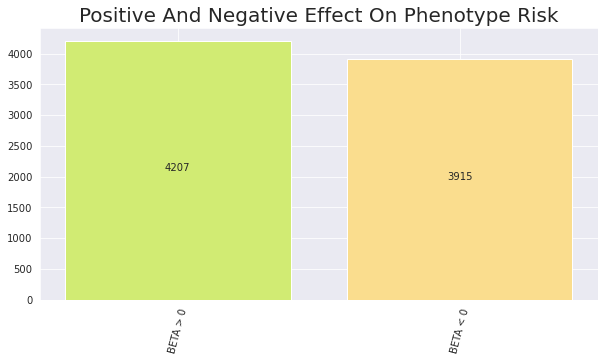

In [26]:
# effect direction count plot

# make plot
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1,figsize=(10, 5))
colors = ['#d1eb73','#fadd8e']
plt.xticks(rotation=75)
ax.bar(x=['BETA > 0','BETA < 0'], height=[sig[sig['BETA']>0].count()[0], 
                                        sig[sig['BETA']<0].count()[0]],color=colors)

# write values on barrs
plt.text('BETA < 0', sig[sig['BETA']<0].count()[0]/2, f"{sig[sig['BETA']<0].count()[0]}", ha='center')

plt.text('BETA > 0', sig[sig['BETA']>0].count()[0]/2, f"{sig[sig['BETA']>0].count()[0]}", ha='center')

# add title and save
ax.set_title('Positive And Negative Effect On Phenotype Risk', fontsize=20)
plt.savefig('./path/dir_sig.png', format='png', bbox_inches='tight')

In [27]:
def prepare_data(mask: str, sig):
    data = sig.sort_values(by='OR')
    data=data.loc[data.groupby(['mask', 'pheno'])['LOG10P'].idxmax()]
    data = data.sort_values(by='OR')
    data = data[data['mask']==mask]
    data['in']=0
    for i in range(len(data)):
        data['in'].iloc[i]=i

    return data

In [28]:
def forest_plot(m: int, data):
    data = data.fillna('N/A')
    sns.set(style='whitegrid')
    plt.figure(figsize=(22,22))
    sns.scatterplot(data=data, x='OR',y='in', hue='LOG10P', size='MAF', sizes=(100,300))
    plt.errorbar(data['OR'],data['in'],xerr=[data['OR']-data['lower'],data['upper']-data['OR']],
                 fmt='none',ecolor='gray',elinewidth=1.5,capsize=3,alpha=0.5)
    plt.axvline(x=1,color='black',linestyle='--')
    plt.ylabel('')
    ax = plt.gca()
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=-1)
    ax.set_ylim(top=len(data))
    ax.axes.yaxis.set_ticklabels([])

    y=1
    h=1/(len(data)+1)
    ma = max(data['upper'])
    mi = min(data['lower'])
    x=ma-mi
    if(x<1):
        x=x/10      

    for i, row in data.iterrows():
        plt.text(-0.1, (row['in']+1)*h, round(row['LOG10P'],4), transform=ax.transAxes)
    plt.text(-0.1, 1, 'log10 P-value', fontsize=12, weight='bold', transform=ax.transAxes)
    
    for i, row in data.iterrows():
        plt.text(-0.26, (row['in']+1)*h, round(row['OR'],2), transform=ax.transAxes)
        plt.text(-0.215, (row['in']+1)*h, "("+str(round(row['lower'],2))+", "
                 +str(round(row['upper'],2))+")", transform=ax.transAxes)
    plt.text(-0.26, y, 'OR (95%CI)', fontsize=12, weight='bold', transform=ax.transAxes)
    
    for i, row in data.iterrows():
        p = row['pheno'].replace("_0_nfe_ri", "").replace("body_mass_index_", "")
        p = '\n'.join(textwrap.wrap(p, width=29))
        plt.text(-0.46, (row['in']+1)*h, p, transform=ax.transAxes)
    plt.text(-0.46, y, 'Phenotype', fontsize=12, weight='bold', transform=ax.transAxes)
    
    for i, row in data.iterrows():
        plt.text(-0.60, (row['in']+1)*h, str(row['cases']), transform=ax.transAxes)
        plt.text(-0.54, (row['in']+1)*h, row['controls'], transform=ax.transAxes)
    if data['pheno_type'].iloc[0]=='binary':
        plt.text(-0.60, y, 'Cases - Controls', fontsize=12, weight='bold', transform=ax.transAxes)
    else:
        plt.text(-0.60, y, 'Observations', fontsize=12, weight='bold', transform=ax.transAxes)

#     for i, row in data.iterrows():
#         plt.text(-28, (row['in']+1)*h, row['mask'], transform=ax.transAxes)
#     plt.text(-28, y, 'Mask', fontsize=12, weight='bold', transform=ax.transAxes)

    for i, row in data.iterrows():
        plt.text(-0.75, (row['in']+1)*h, row['ID2'], transform=ax.transAxes)
    plt.text(-0.75, y, 'Regulatory ID', fontsize=12, weight='bold', transform=ax.transAxes)

    for i, row in data.iterrows():
        plt.text(-0.85, (row['in']+1)*h, row['MAF'], transform=ax.transAxes)
    plt.text(-0.85, y, 'MAF  Cut-off', fontsize=12, weight='bold', transform=ax.transAxes)

    for i, row in data.iterrows():
        plt.text(-1.02, (row['in']+1)*h, row['GENPOS'], transform=ax.transAxes)
        plt.text(-0.95, (row['in']+1)*h, "(8e5)", transform=ax.transAxes)
    plt.text(-1.02, y, 'Position (Search Range)', fontsize=12, weight='bold', transform=ax.transAxes)

    for i, row in data.iterrows():
        n = '\n'.join(textwrap.wrap(str(row['gene_name']), width=20))
        plt.text(-1.24, (row['in']+1)*h, row['ensembl_gene_id'], transform=ax.transAxes)
        plt.text(-1.13, (row['in']+1)*h, "(" + n + ")", transform=ax.transAxes)
    plt.text(-1.24, y, 'Nearest Protein_coding Gene', fontsize=12, weight='bold', transform=ax.transAxes)
    
    for i, row in data.iterrows():
        plt.text(-1.385, (row['in']+1)*h, row['num_var'], transform=ax.transAxes)
    plt.text(-1.385, y, 'Number of Variants', fontsize=12, weight='bold', transform=ax.transAxes)
    
    for i, row in data.iterrows():
        s ='\n'.join(textwrap.wrap(row['snp_start_pos'], width=26))
        e = '\n'.join(textwrap.wrap(row['snp_end_pos'], width=26))
        plt.text(-1.735, (row['in']+1)*h, s, transform=ax.transAxes)
        plt.text(-1.56, (row['in']+1)*h, e, transform=ax.transAxes)
    plt.text(-1.735, y, 'Regulatory Start', fontsize=12, weight='bold', transform=ax.transAxes)
    plt.text(-1.56, y, 'Regulatory Finish', fontsize=12, weight='bold', transform=ax.transAxes)
    
    if data['pheno_type'].iloc[0]=='binary':
        ax.set_title(data['mask'].iloc[0]+' Significant Results Forestplot - Binary', fontsize=20)
    else:
        ax.set_title(data['mask'].iloc[0]+' Significant Results Forestplot - Quantitative', fontsize=20)
    plt.savefig(".path/forest_plot_"+data['pheno_type'].iloc[0]+"_"+str(m)+".png",
                format='png', bbox_inches='tight')
    plt.show()


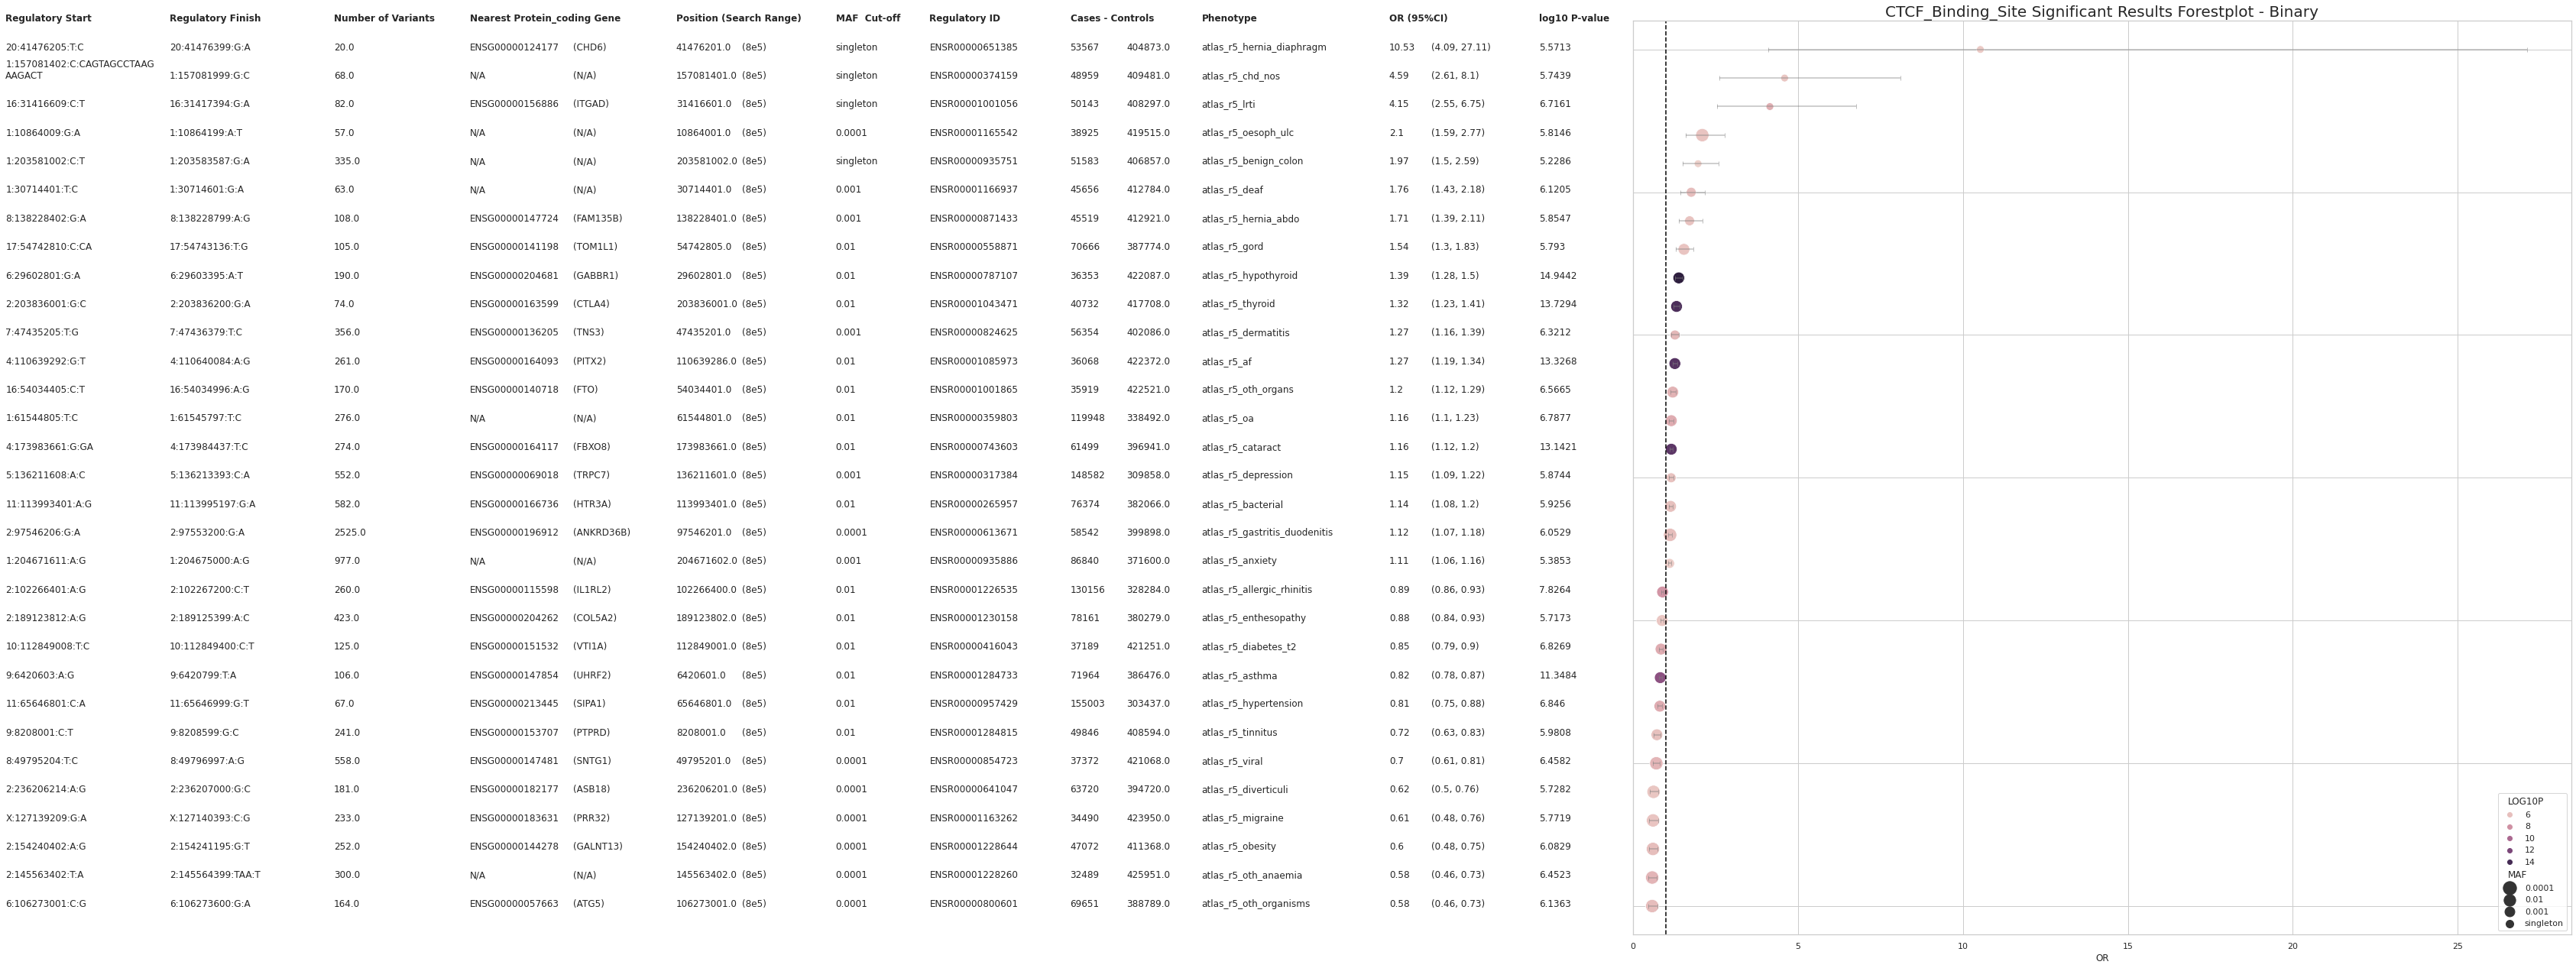

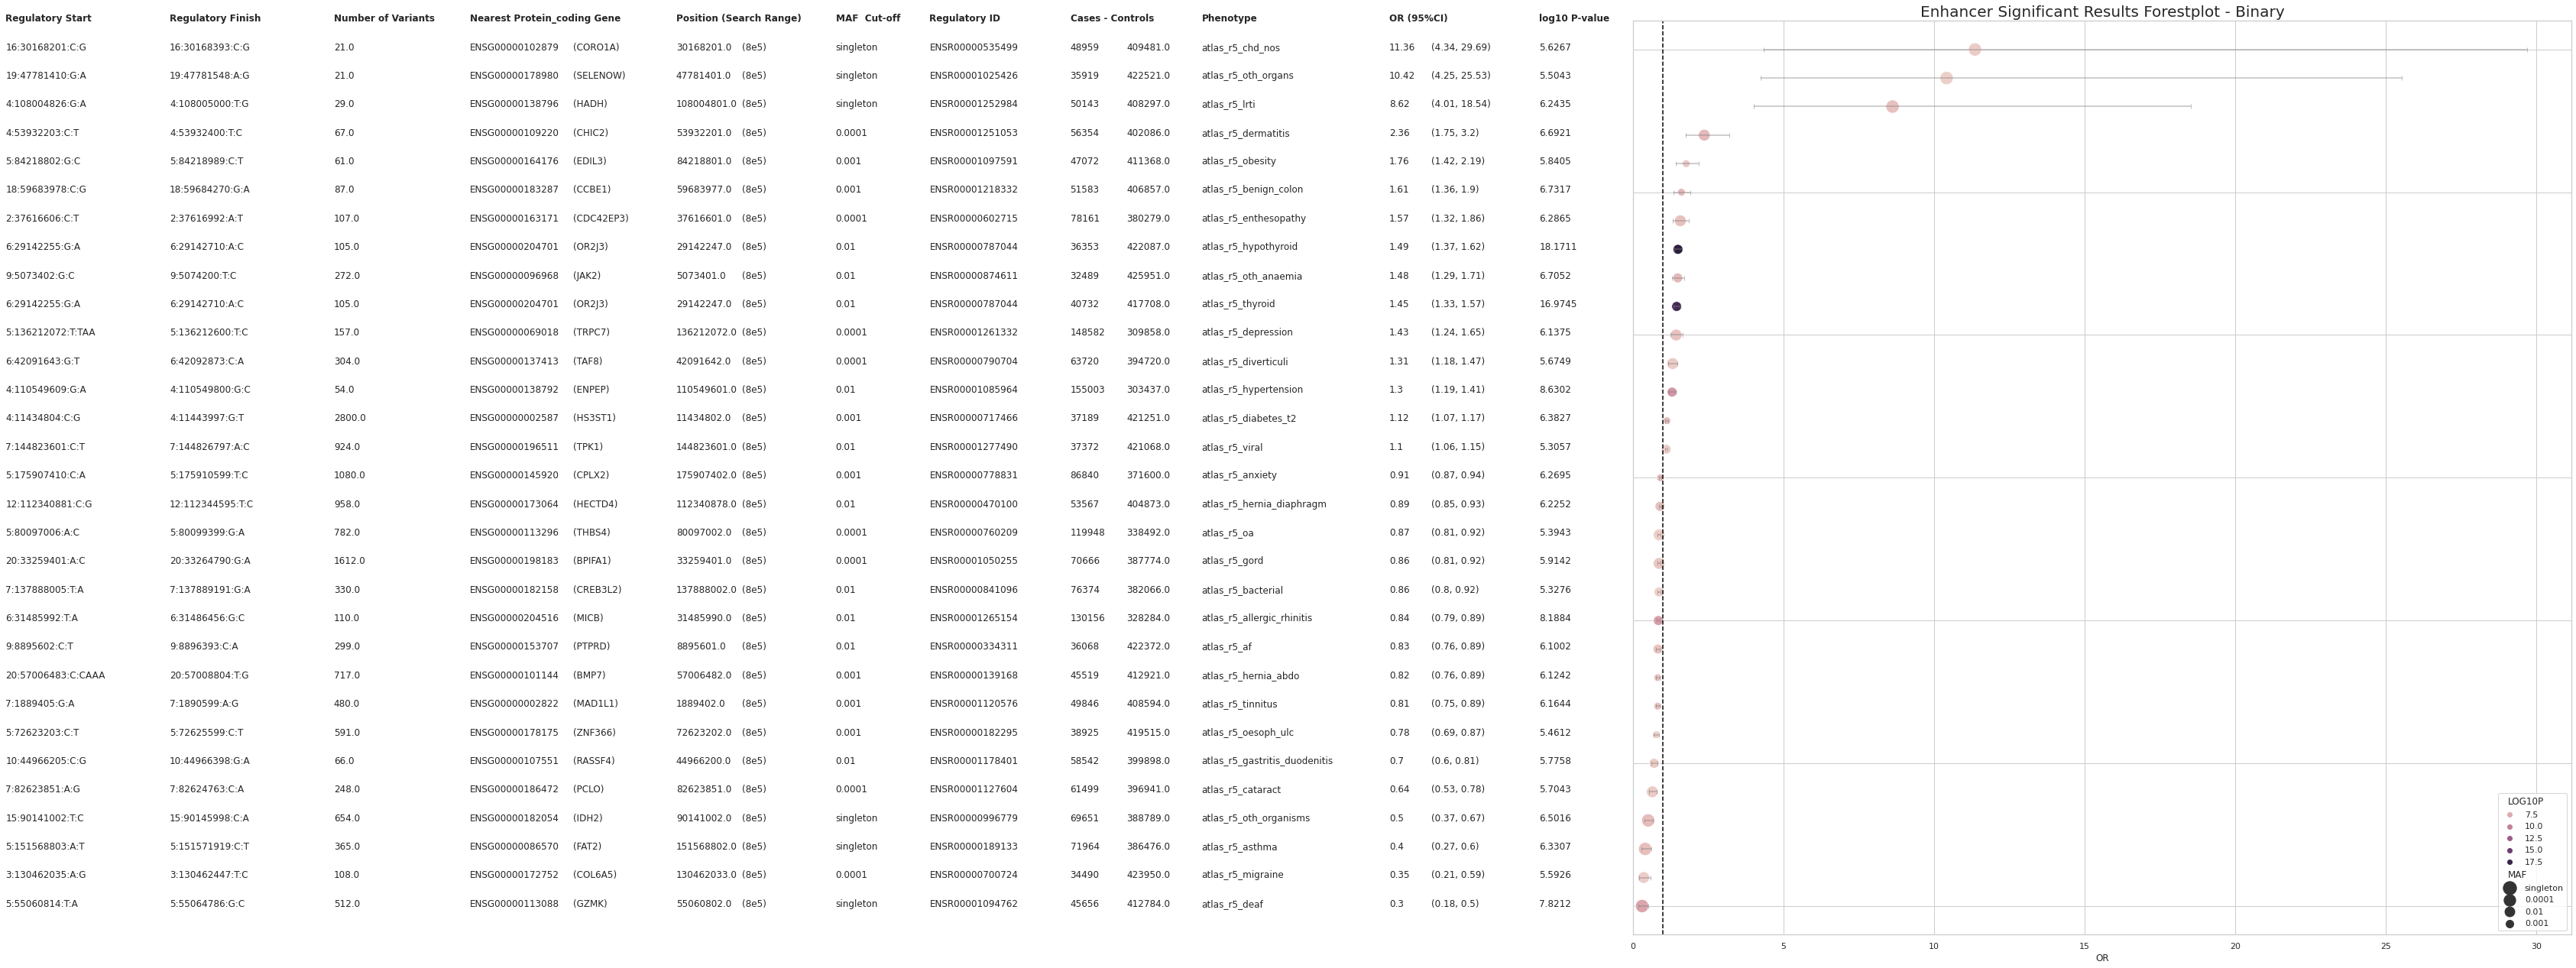

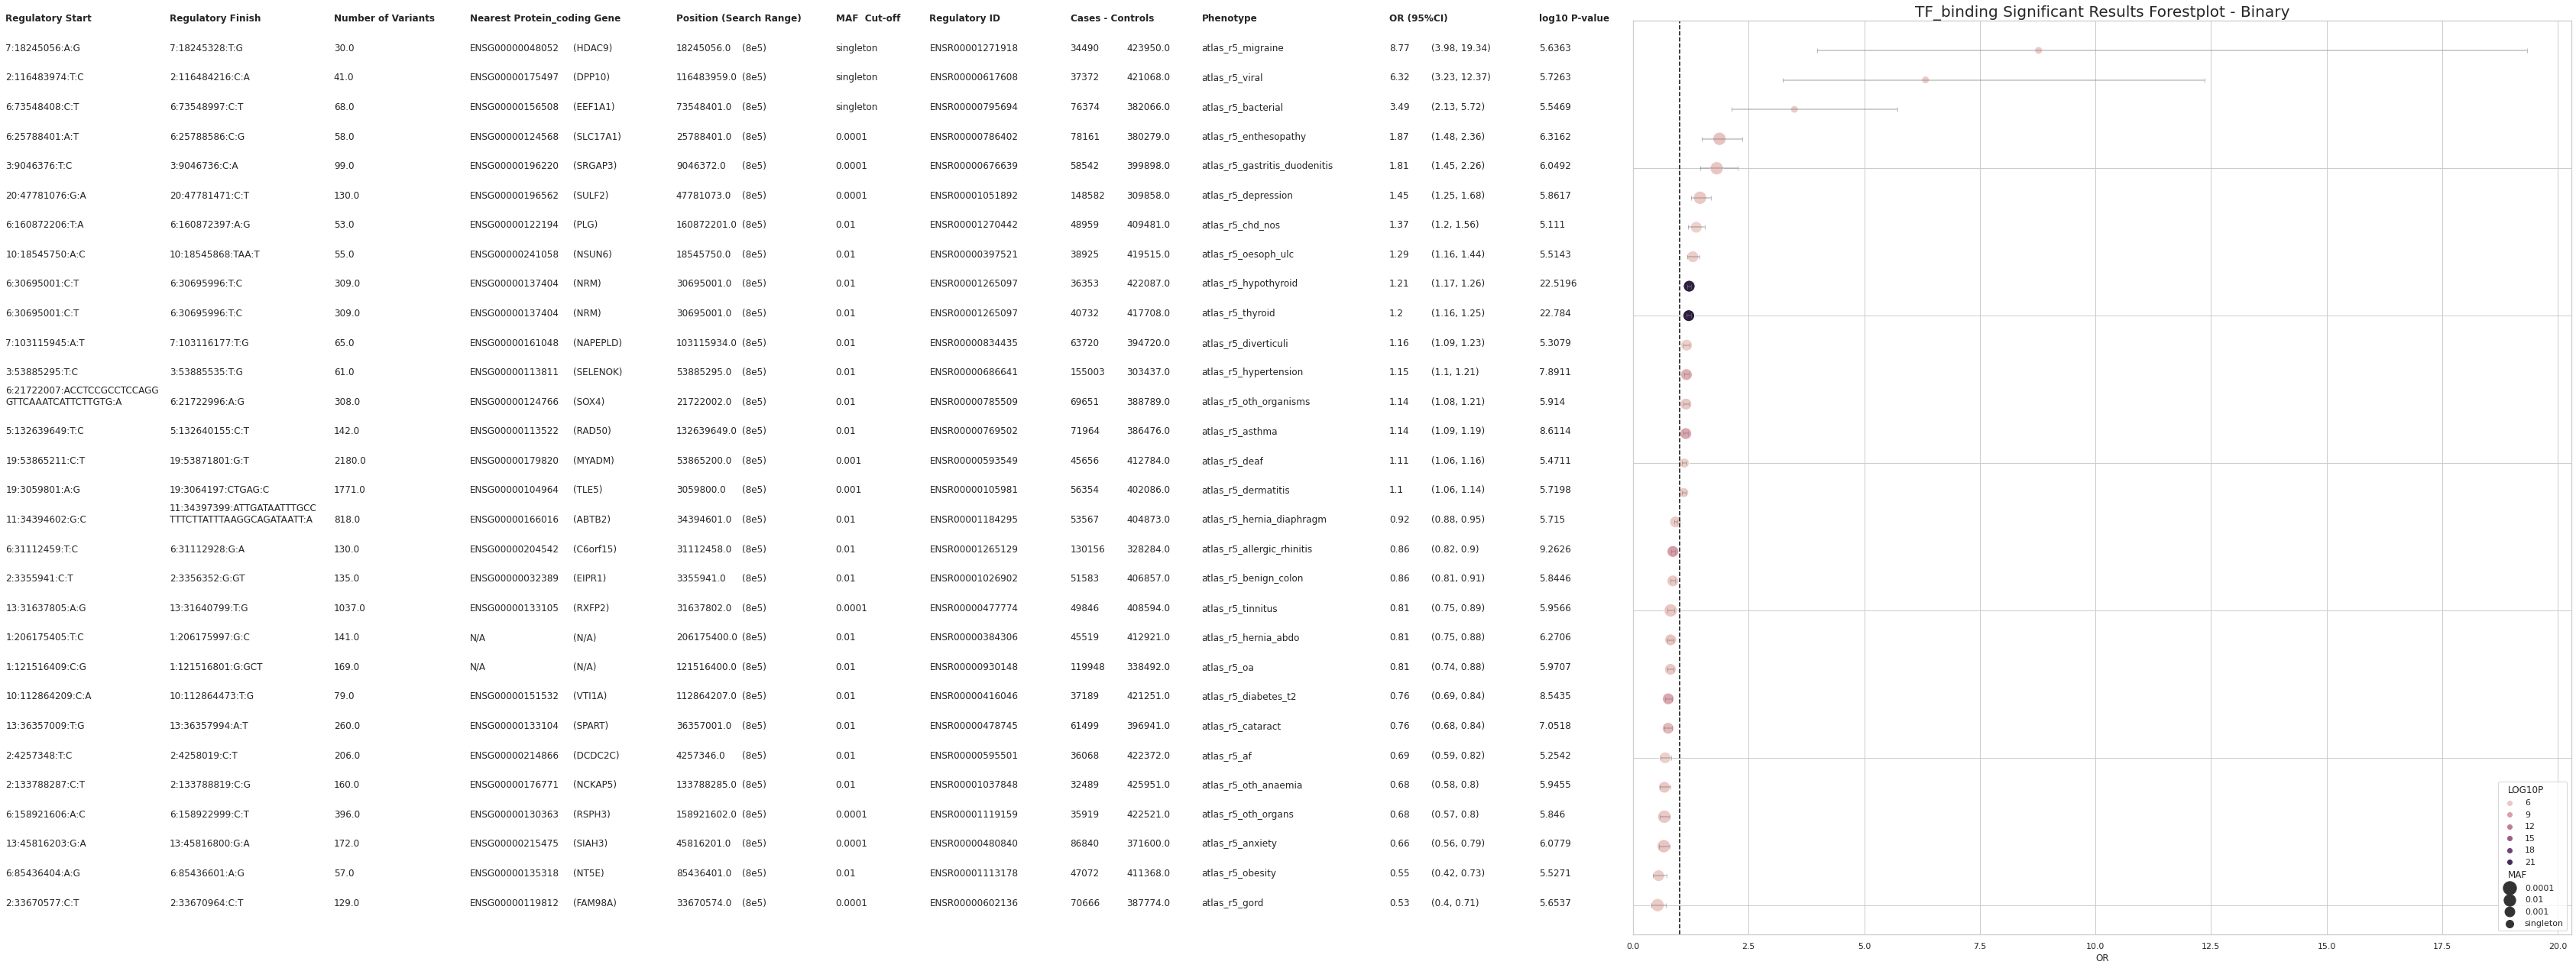

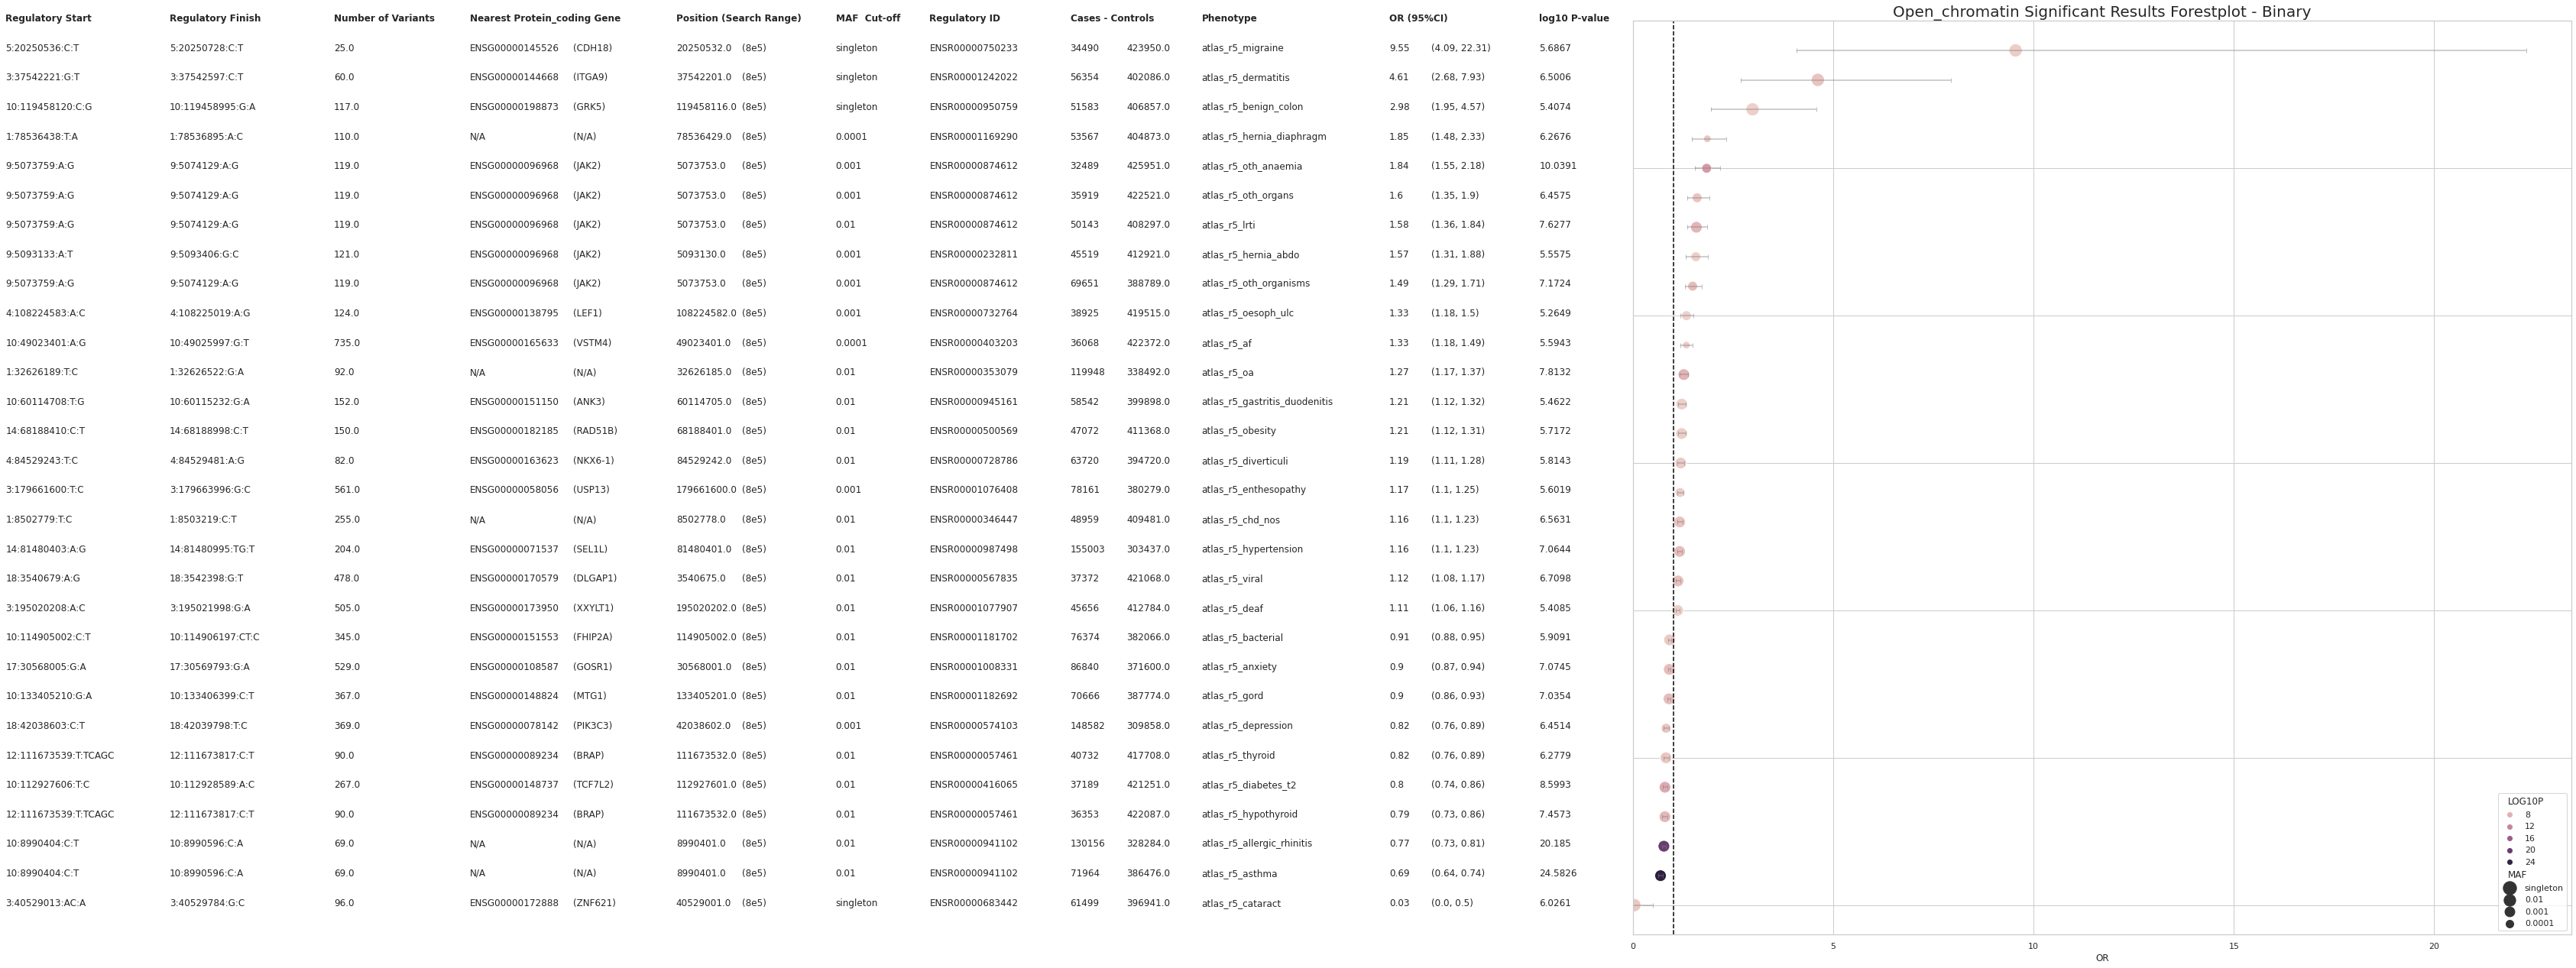

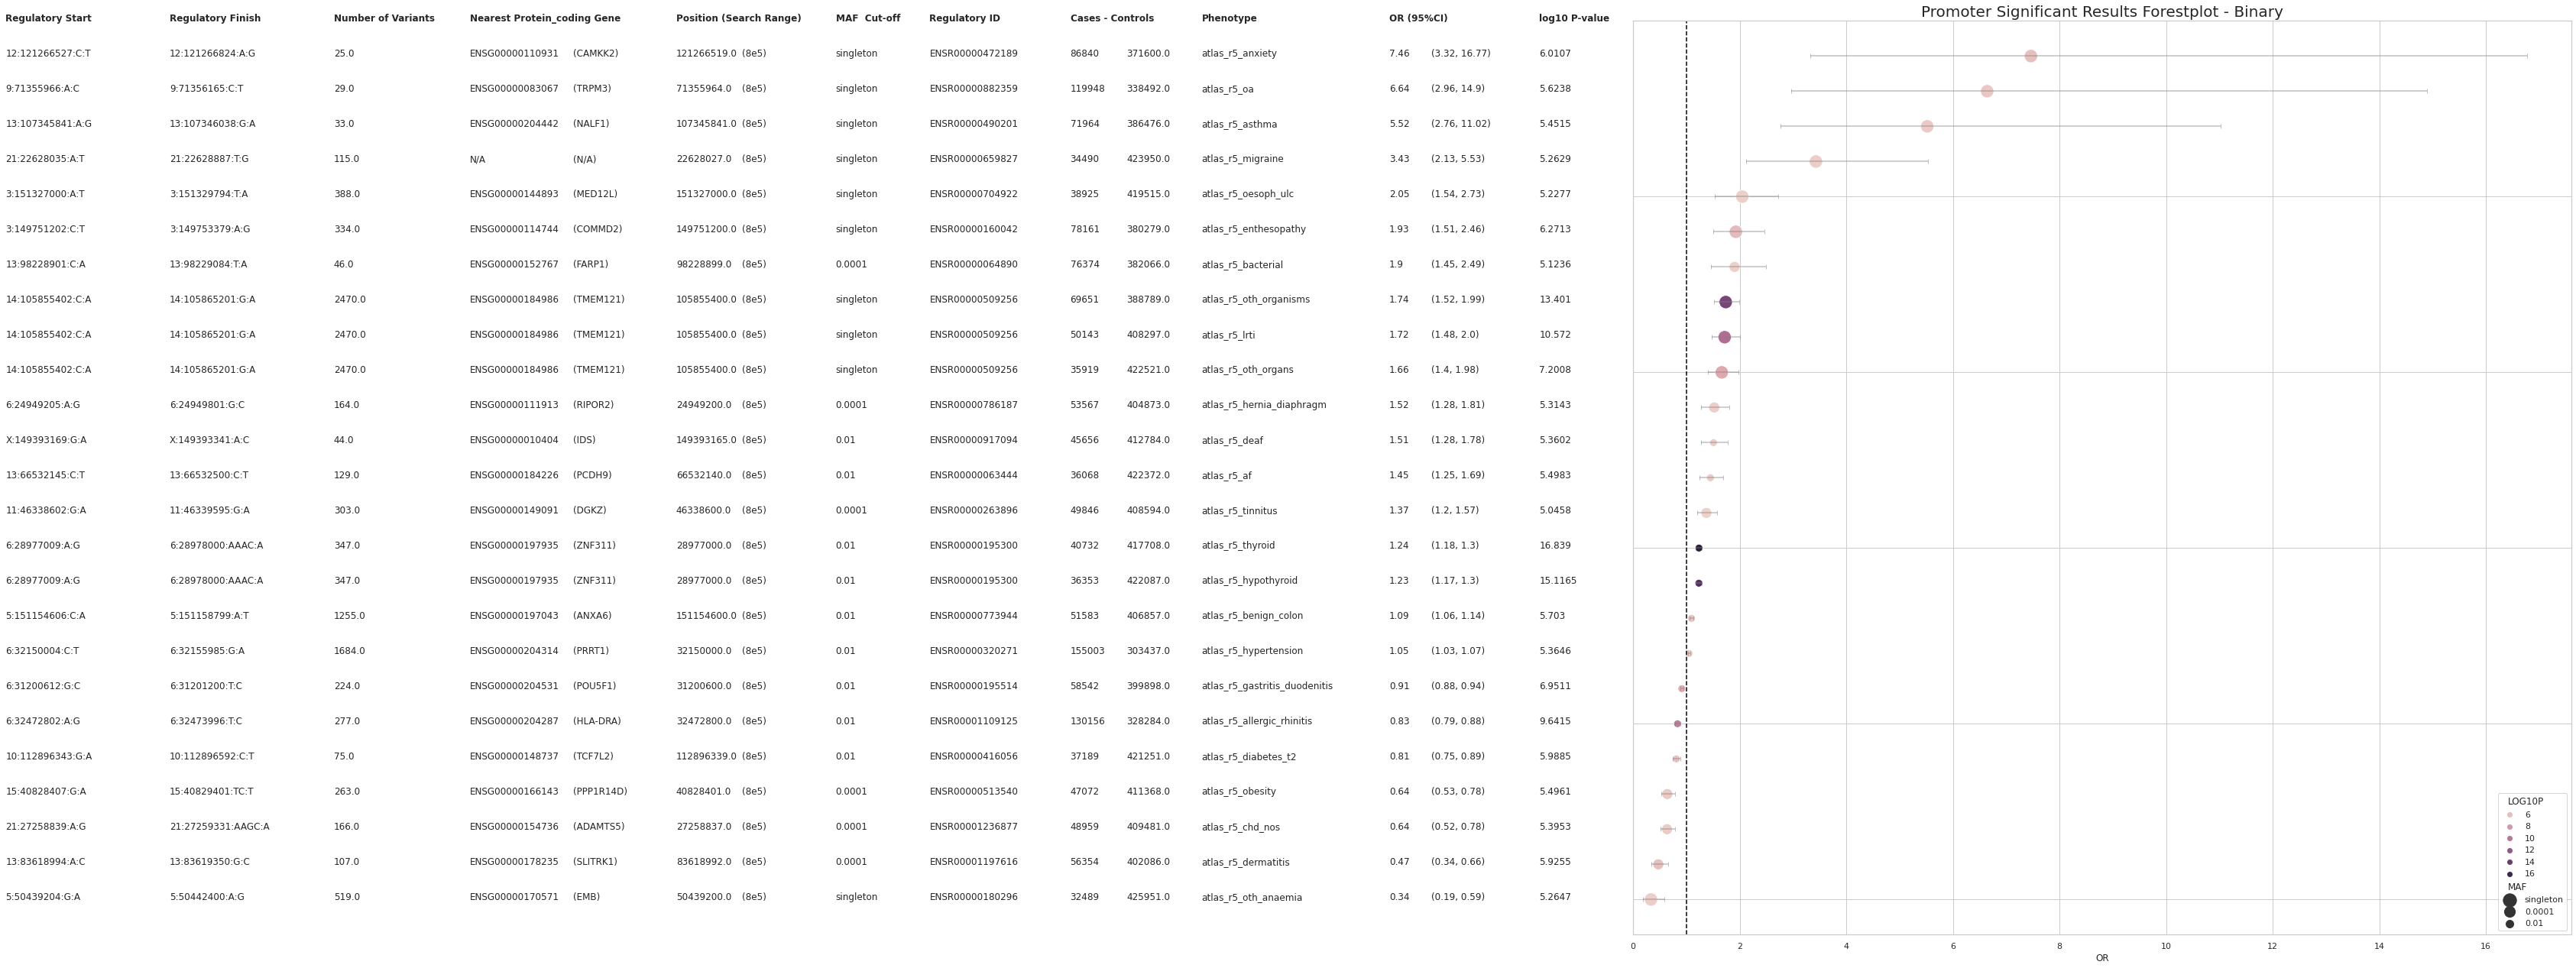

In [29]:
for m in range(len(msk)):
    data = prepare_data(msk[1].iloc[m], sig[sig['pheno_type']=='binary'])
    forest_plot(m, data)
    

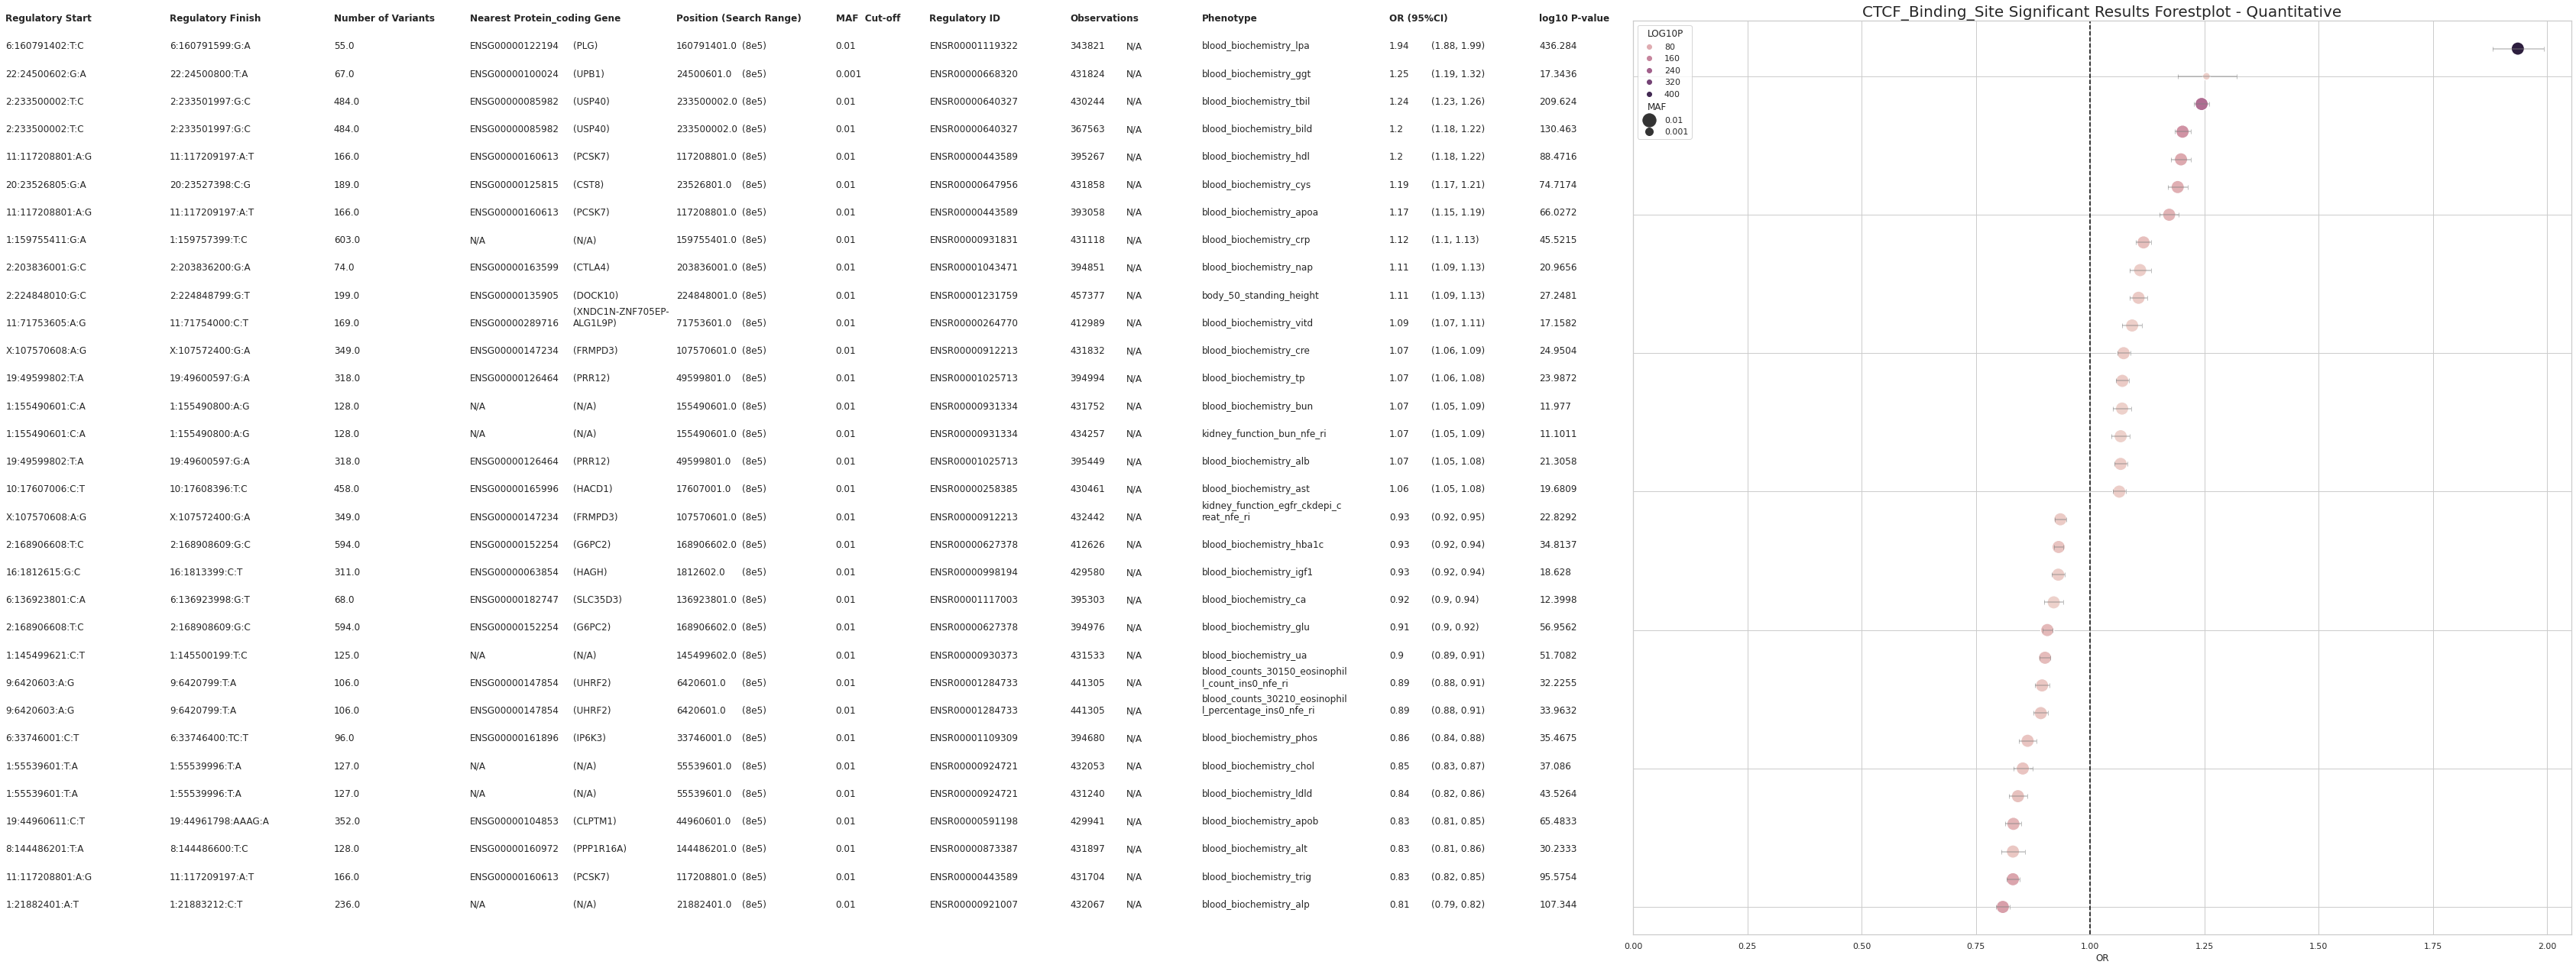

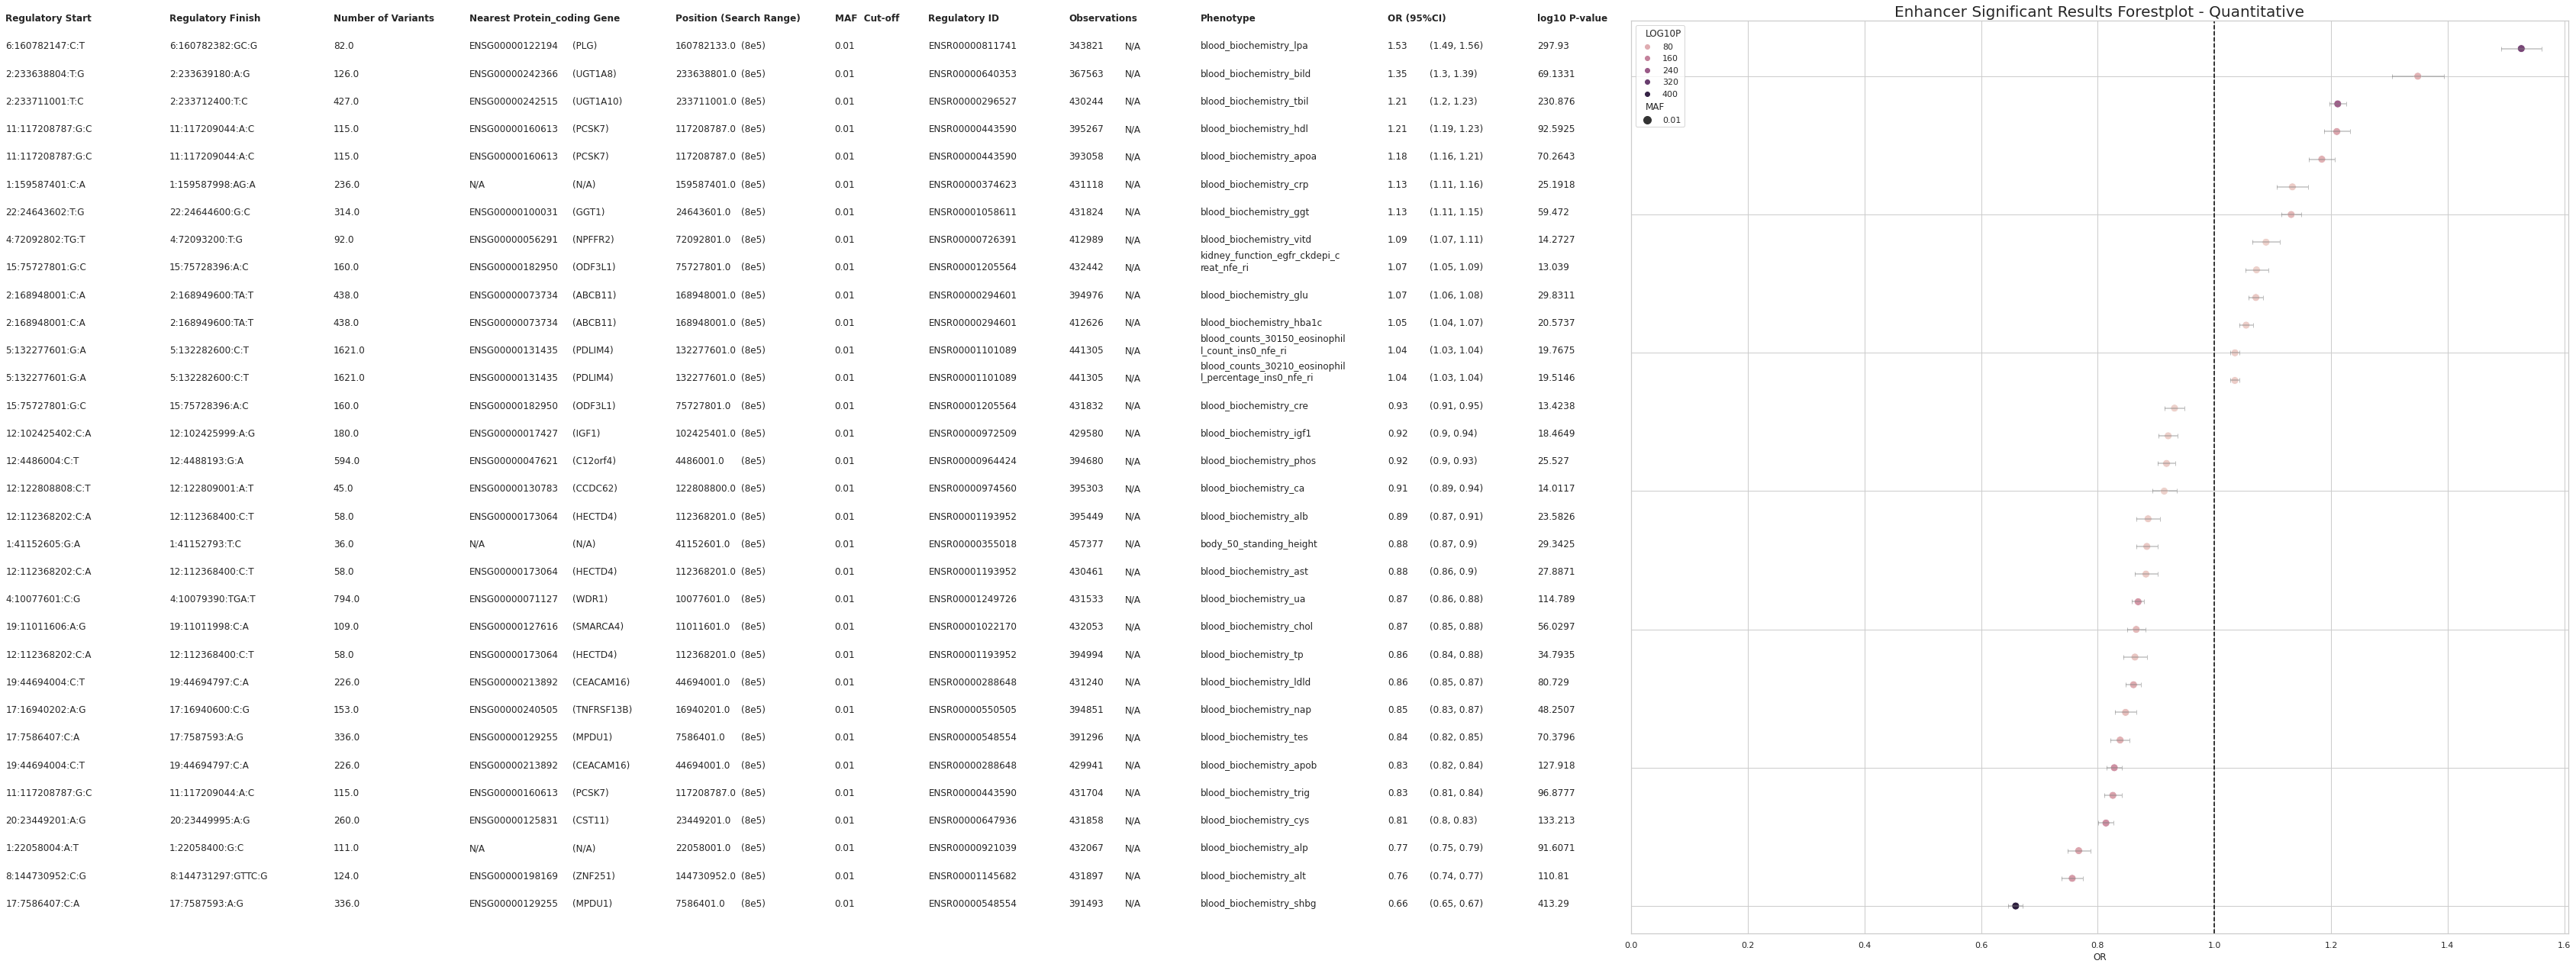

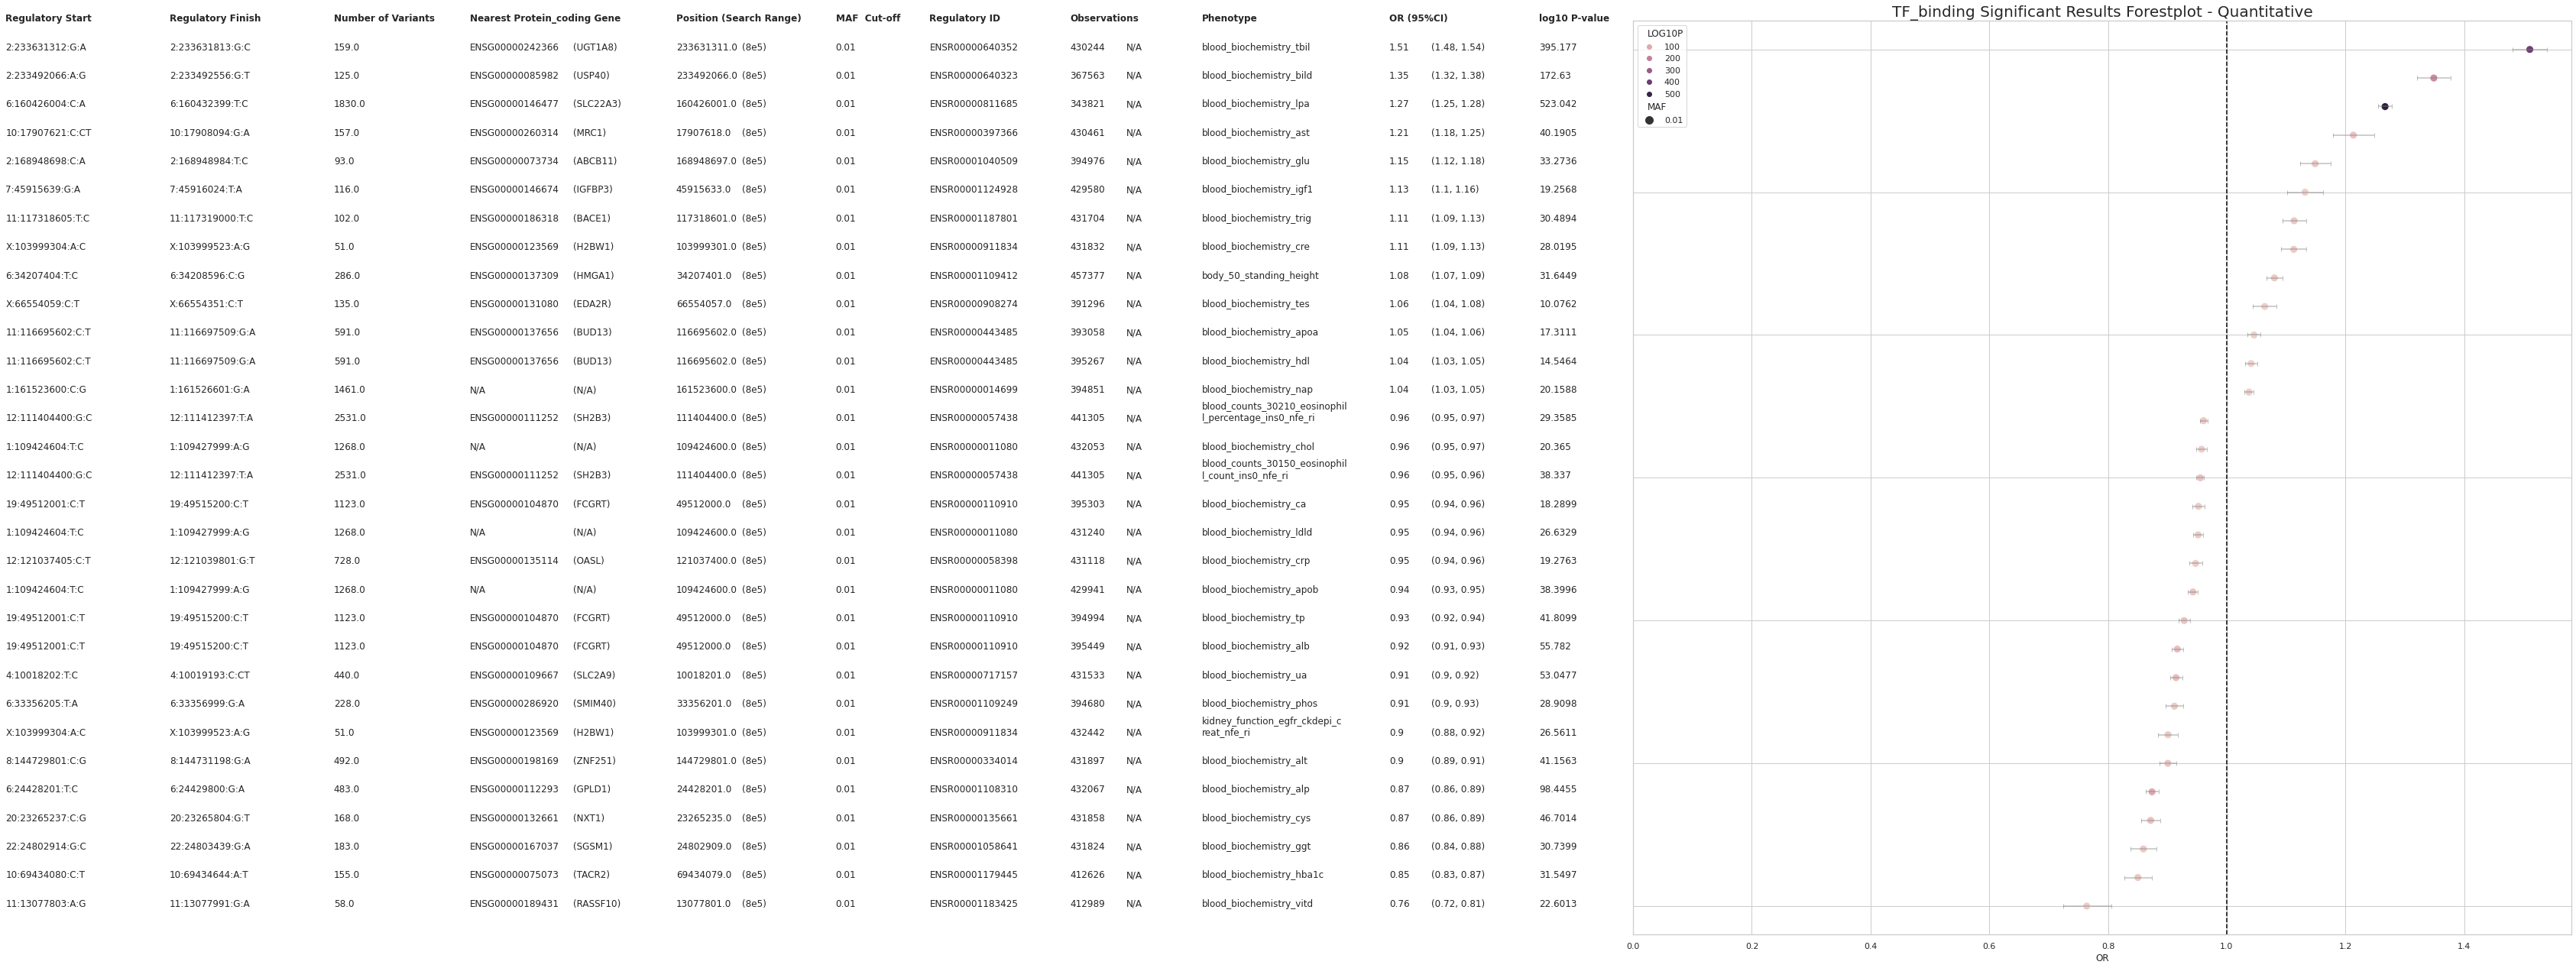

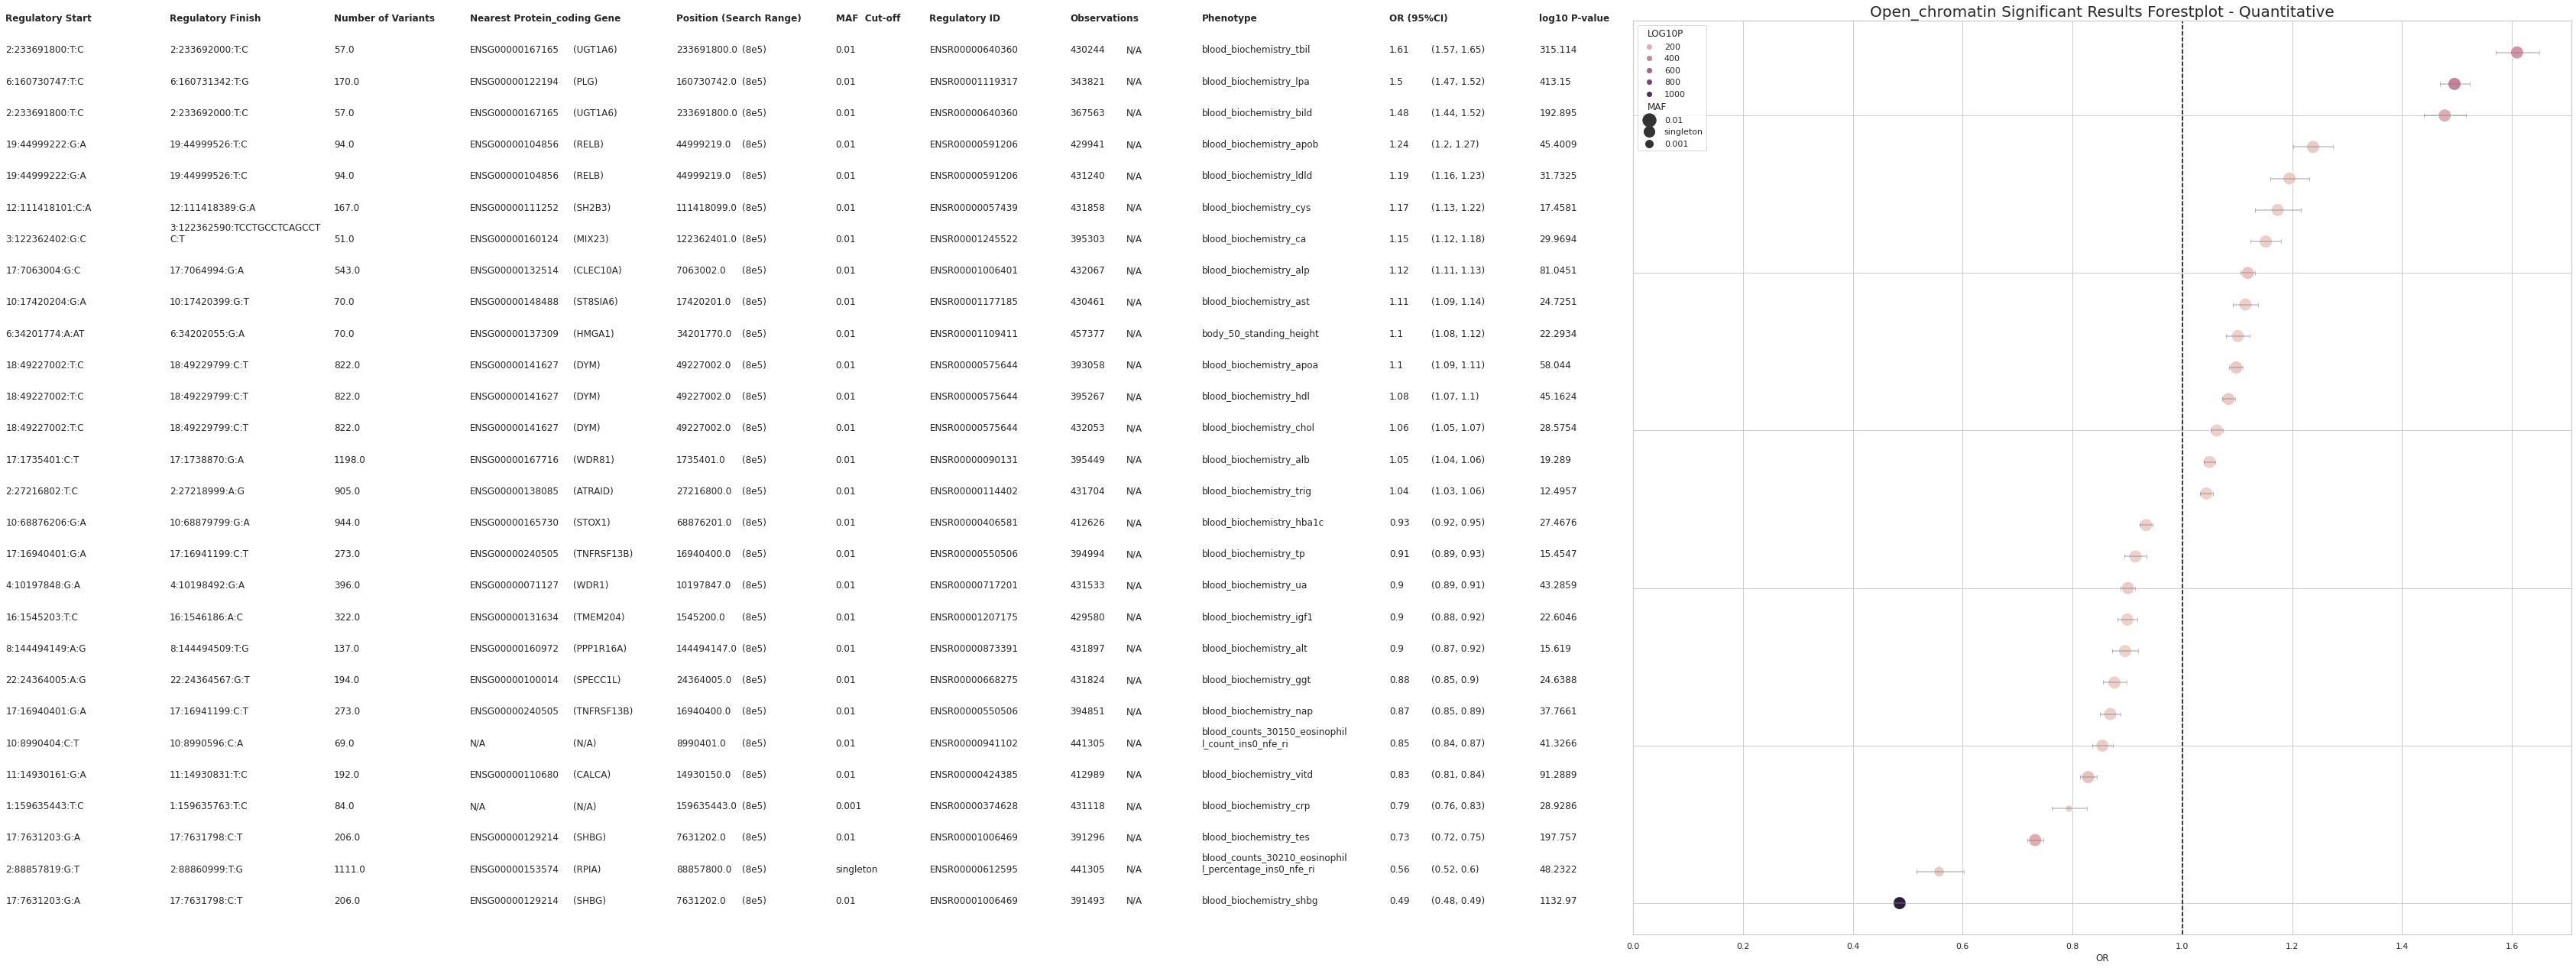

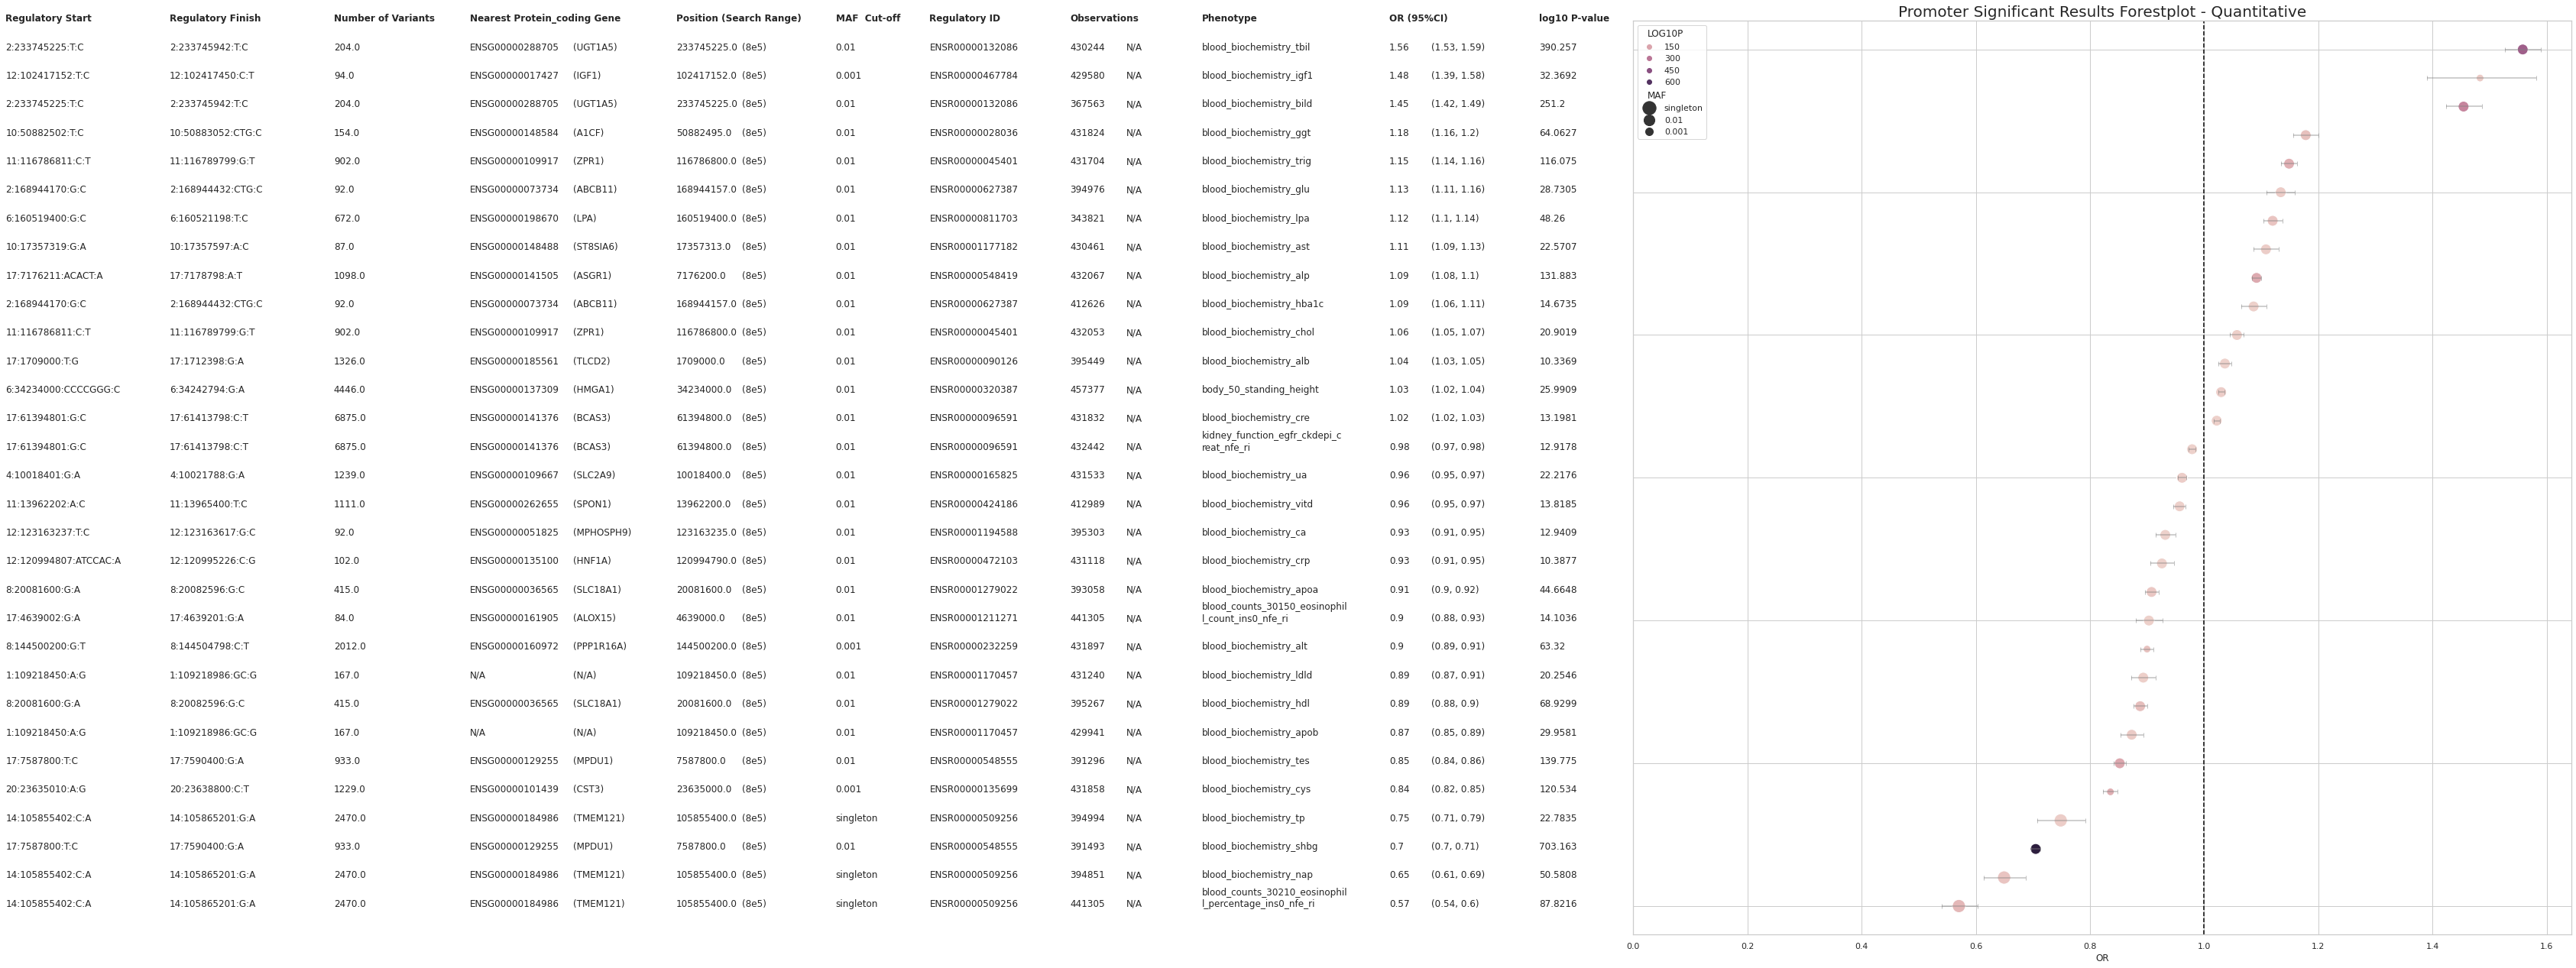

In [30]:
for m in range(len(msk)):
    data = prepare_data(msk[1].iloc[m], sig[(sig['pheno_type']=='quan') & (sig['LOG10P']>10)])
    forest_plot(m, data)

In [16]:
# get gene-pheno associations with more than one mask
grouped = sig[['ensembl_gene_id','pheno','mask','LOG10P']]
grouped = grouped.groupby(['ensembl_gene_id','pheno','mask']).filter(lambda x: x['mask'].nunique()>1)
print(grouped)

Empty DataFrame
Columns: [ensembl_gene_id, pheno, mask, LOG10P]
Index: []


In [7]:
# imports for reading GWAS table
import pyodbc
import getpass
from pathlib import Path

# Need a list of target phenotypes
phenotypes = sig['pheno'].unique().tolist()

In [8]:
# Login, usr is mudid ID
usr = "as028527"
pwd = getpass.getpass()

# Connect
conn = pyodbc.connect(DSN='impala-sccprd', UID=usr, PWD=pwd, autocommit=True)


········


In [9]:
###
# Create phenotype search terms for the GWAS table
###

queries = {}
for pheno in phenotypes:
    # atlas
    if "atlas" in pheno:
        name = pheno.replace("5", "4")
        query = f"ukb_gsk_g3_{name}"
    # blood count
    elif "blood_counts" in pheno:
        info = pheno.split("_")
        name = ("_").join(info[:-3])
        query = f"ukb_gsk_g3_rg_{name}"
    # blood biochemistry
    elif "blood_biochemistry" in pheno:
        info = pheno.split("_")
        name = info[2]
        query = f"ukb_gsk_g3_rg_bio_{name}_ri"
    # kidney function
    elif "kidney_function" in pheno:
        info = pheno.split("_")
        # if simple case
        if len(info) == 5:
            name = info[2]
            query = f"kidney_function_{name}_ri"
    # Manual - some challenging cases
    else:
        if pheno == "bp_4080_systolic_blood_pressure_0_nfe_ri":
            query = "ukb_gsk_g3_rg_srq_systolic_blood_pressure_sbp_ri"
        elif pheno == "body_50_standing_height_0_nfe_ri":
            query = "ukb_gsk_g3_rg_body_50_standing_height_ri"
        elif pheno == "body_impedance_23104_body_mass_index_bmi_0_nfe_ri":
            query = "ukb_gsk_g3_rg_body_impedance_23104_body_mass_index_bmi_ri"
    # Update database
    queries[pheno] = query


In [11]:
###
# Connect to GWAS table, search and report mappings
###
pval = {}
chroms = {}
gwas_map = {}
for pheno in phenotypes:
    fetch = queries[pheno]
    sql_query = f"""
    SELECT DISTINCT analysis
    from gene_gwas_hg38_use.gwas_results_cond_hits
        WHERE analysis LIKE '%{fetch}%'
    """
    sql_query2 = f"""
    SELECT analysis, pvalue_cond
    from gene_gwas_hg38_use.gwas_results_cond_hits
        WHERE analysis LIKE '%{fetch}%'
    """

    
    # Read in search results
    results = pd.read_sql(sql_query, conn)
    results2 = pd.read_sql(sql_query2, conn)
    
    
    # Confirm you pulled down only your target
    matches = results['analysis'].unique()
    if 0 < len(matches) <= 1:
        gwas_map[pheno] = matches[0]
    elif len(matches) == 0:
        gwas_map[pheno] = "NO_MATCH"
    elif len(matches) >=2:
        gwas_map[pheno] = "MULTIPLE_MATCHES"
    
    pval[pheno] = results2['pvalue_cond'].min()
    
    if not math.isnan(pval[pheno]):
        # Define query
        sql_query3 = f"""
        SELECT analysis, pvalue_cond, assay_chrom
        from gene_gwas_hg38_use.gwas_results_cond_hits
            WHERE analysis LIKE '%{fetch}%' AND pvalue_cond={pval[pheno]}
        """

        # Read in search results
        results3 = pd.read_sql(sql_query3, conn)

        chroms[pheno] = results3['assay_chrom'].unique()
    else:
        chroms[pheno] = []


In [57]:
###
# Build result and write out
###

map_data = []
for pheno in phenotypes:
    tag = queries[pheno]
    gwas = gwas_map[pheno]
    pvalue = pval[pheno]
    chrom = chroms[pheno]
    map_data.append([pheno, tag, gwas, pvalue, chrom])

# Write out
map_table = pd.DataFrame(map_data, columns=["regenie_pheno", "gwas_search_term","gwas_pheno", "pvalue", "chromosomes"])
map_table.to_csv("./path/gwas_sig-gene-trait.tsv", index=False, sep='\t')

In [12]:
# To read gwas_sig_gene_trait if needed
map_table = r"./path/gwas_sig-gene-trait.tsv"
map_table = pd.read_csv(map_table, sep="\t")

In [181]:
# Get most common chromosome accross gwas phenos
nona = map_table[map_table['pvalue'].notna()]
all_nums = [num for sublist in nona['chromosomes'] for num in sublist]
counts = Counter(all_nums)
counts

Counter({'[': 60,
         "'": 712,
         '1': 206,
         ']': 60,
         '5': 28,
         ' ': 296,
         '4': 30,
         '7': 39,
         '2': 72,
         '9': 38,
         '6': 37,
         '8': 30,
         '0': 29,
         '3': 21,
         '\n': 5})

In [13]:
# Get gwas to reg phenotype name converter df
mymap = map_table[['gwas_pheno','regenie_pheno']].drop_duplicates(['gwas_pheno'])
mymap = mymap.set_index('gwas_pheno')

In [14]:
# get rid of any pheno without gwas match
mymap=mymap.drop('NO_MATCH')

In [15]:
# Check how many significant phenotype values have a gwas match
map_table2=map_table.drop(map_table[map_table['gwas_pheno']=='NO_MATCH'].index)
sig['pheno'].isin(map_table2['regenie_pheno']).sum()

6347

In [16]:
# Check how many significant phenotype values have a gwas (with low pval) match
map_table2 = map_table[map_table['pvalue']< 2.5e-08]
sig['pheno'].isin(map_table2['regenie_pheno']).sum()

6320

In [69]:
print(5 * 10**-8)

5e-08


In [24]:
chroms = sig['CHROM'].unique()

In [17]:
###
# Create phenotype search terms for the GWAS table
###

phenotypes = pd.read_csv("./path/phenotype.tsv", sep="\t", header=None)
queries = {}
for pheno in phenotypes[0]:
    query=''
    # atlas
    if "atlas" in pheno:
        name = pheno.replace("5", "4")
        query = f"ukb_gsk_g3_{name}"
    # blood count
    elif "blood_counts" in pheno:
        info = pheno.split("_")
        name = ("_").join(info[:-3])
        query = f"ukb_gsk_g3_rg_{name}"
    # blood biochemistry
    elif "blood_biochemistry" in pheno:
        info = pheno.split("_")
        name = info[2]
        query = f"ukb_gsk_g3_rg_bio_{name}_ri"
    # kidney function
    elif "kidney_function" in pheno:
        info = pheno.split("_")
        # if simple case
        if len(info) == 5:
            name = info[2]
            query = f"kidney_function_{name}_ri"
    # Manual - some challenging cases
    else:
        if pheno == "bp_4080_systolic_blood_pressure_0_nfe_ri":
            query = "ukb_gsk_g3_rg_srq_systolic_blood_pressure_sbp_ri"
        elif pheno == "body_50_standing_height_0_nfe_ri":
            query = "ukb_gsk_g3_rg_body_50_standing_height_ri"
        elif pheno == "body_impedance_23104_body_mass_index_bmi_0_nfe_ri":
            query = "ukb_gsk_g3_rg_body_impedance_23104_body_mass_index_bmi_ri"
    # Update database
    queries[pheno] = query


In [27]:
desc = pd.DataFrame()

for pheno in phenotypes[0]:
    fetch = queries[pheno]
    sql_query = f"""
        SELECT * 
        FROM gene_gwas_hg38_use.analyses
        WHERE analysis ='{fetch}'
        """
    
    # Read in search results and add to df
    results = pd.read_sql(sql_query, conn)
    desc = pd.concat([desc, results])

# Replace gwas pheno names with reg pheno names
desc['analysis']=desc['analysis'].map(mymap['regenie_pheno'])

# save description file
path = r"./path/descr.tsv"
desc.to_csv(path, index=False, sep='\t')
desc

In [24]:
# Read desc if needed
path = r"/path/descr.tsv"
desc = pd.read_csv(path, sep='\t')

In [70]:
# drop uneeded columns
desc.drop('phenotype_vocab_label',axis=1,inplace=True)
desc.drop('entity_type',axis=1,inplace=True)
desc.drop('phenotype_vocab_id',axis=1,inplace=True)
desc.drop('pubmedid',axis=1,inplace=True)
desc.drop('covariates',axis=1,inplace=True)
desc.drop('phenotype',axis=1,inplace=True)
desc.drop('has_rsq',axis=1,inplace=True)
desc.drop('has_freq',axis=1,inplace=True)
desc.drop('unit',axis=1,inplace=True)
desc.drop('cohort',axis=1,inplace=True)
desc.drop('uoi',axis=1,inplace=True)
desc.drop('update_date',axis=1,inplace=True)

In [67]:
# change column types
desc['phenotype_vocab_parent_nodes'] = desc['phenotype_vocab_parent_nodes'].astype(str)
desc['rumt_interested'] = desc['rumt_interested'].astype(str)

# wrap text so it isnt too long and goes to the next line
for i, row in desc.iterrows():
    desc['analysis'].iloc[i] ='\n'.join(textwrap.wrap(row['analysis'], width=25))
    desc['description'].iloc[i] ='\n'.join(textwrap.wrap(row['description'], width=70))
    desc['label'].iloc[i] ='\n'.join(textwrap.wrap(row['label'], width=20))
    desc['phenotype_vocab_parent_nodes'].iloc[i] ='\n'.join(textwrap.wrap(row['phenotype_vocab_parent_nodes'], width=30))
    desc['rumt_interested'].iloc[i] ='\n'.join(textwrap.wrap(row['rumt_interested'], width=20))

In [28]:
def render_mpl_table(data, fig_width=2, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None):
    '''
    Function for plotting the phenotype table
    
    ------
    input params self-evident
    ------
    returns fig and ax
    
    '''
    if ax is None:
        # calculate size
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([fig_width, row_height])
        # set size        
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    # draw plot  
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, cellLoc='center')
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    
    # fix design    
    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
            
        cell.set_width(col_width[k[1]])
        
    return ax.get_figure(), ax



# creat plot
fig, ax = render_mpl_table(desc, header_columns=0, col_width=[4,1.5,1.5,
                                                             1.5,1.5], row_height=2.48)

# save plot
fig.savefig('./path/phenotype_descrip.png', format='png', bbox_inches='tight')

In [31]:
###
# Connect to GWAS table, search and get info per chrom
###
gwas_hit = None
chroms = sig['CHROM'].unique()

for chro in chroms:
    sql_query = f"""
    SELECT DISTINCT analysis, pvalue_cond, assay_chrom, assay_pos
    from gene_gwas_hg38_use.gwas_results_cond_hits
        WHERE assay_chrom='{chro}';
    """
    # Read in search results and add to df
    results = pd.read_sql(sql_query, conn)
    gwas_hit = pd.concat([gwas_hit, results])
    print(chro, end=' ')

        
gwas_hit

In [97]:
# add pheno name in sig file and fix column type and exclude na
gwas_hit['regenei_pheno']=gwas_hit['analysis'].map(mymap['regenie_pheno'])
gwas_hit['assay_pos']=gwas_hit['assay_pos'].astype(int)
gwas_hit = gwas_hit[gwas_hit['regenei_pheno'].notna()]

# save file
gwas_hit.to_csv("./path/all_gwas_sig_region_based.tsv", index=False, sep='\t')

In [89]:
###
# Connect to GWAS table, search and report significant results per chrom
###
chro_hit = None
chroms = sig['CHROM'].unique()

for chro in chroms:
    sql_query = f"""
    SELECT DISTINCT analysis, pvalue_cond, assay_chrom, assay_pos
    from gene_gwas_hg38_use.gwas_results_cond_hits
        WHERE assay_chrom='{chro}' AND pvalue_cond<2.5e-8;
    """
    # Read in search results and add to df
    results = pd.read_sql(sql_query, conn)
    chro_hit = pd.concat([chro_hit, results])
    print(chro)

        
chro_hit

In [96]:
# Prepare and save gwas_sig_region-based (significant for bot gwas and associations, mapped on basis of chrom)
chro_hit['regenei_pheno']=chro_hit['analysis'].map(mymap['regenie_pheno'])
chro_hit.to_csv("./path/gwas_sig_region_based.tsv", index=False, sep='\t')

In [169]:
# read file if needed
chro_hit = r"./path/gwas_sig_region_based.tsv"
chro_hit = pd.read_csv(chro_hit, sep="\t")

In [183]:
# Get number of sig(10) associations near(same chrom) gwas (true) and novel signals (false)
a=sig.copy()
a=a[a['LOG10P']>10]
a['CHROM']=a['CHROM'].astype(str)
a['gwas']=False
for i, row in a.iterrows():
    match=False
    for j, row2 in map_table.iterrows():
        if row['pheno'] == row2['regenie_pheno'] and row['CHROM'] in row2['chromosomes']:
            match=True
            break
    a.at[i,'gwas']=match
    
a['gwas'].value_counts()

True     1234
False     419
Name: gwas, dtype: int64

In [185]:
# Num of sig association gwas mappings per chrom
a['CHROM'].value_counts()

6     364
2     188
19    166
1     145
17     97
11     92
4      91
12     90
20     76
16     69
9      46
22     43
10     37
8      36
15     30
3      26
5      20
14     13
7      10
18      6
X       6
13      2
Name: CHROM, dtype: int64

In [186]:
# Num of sig association and sig gwas mappings per chrom
a=sig.copy()
a=a[a['LOG10P']>10]
a['CHROM']=a['CHROM'].astype(str)
a['gwas']=False
sigg = map_table[map_table['pvalue']>2.5e-8]
for i, row in a.iterrows():
    match=False
    for j, row2 in sigg.iterrows():
        if row['pheno'] == row2['regenie_pheno'] and row['CHROM'] in row2['chromosomes']:
            match=True
            break
    a.at[i,'gwas']=match
    
a['CHROM'].value_counts()

6     364
2     188
19    166
1     145
17     97
11     92
4      91
12     90
20     76
16     69
9      46
22     43
10     37
8      36
15     30
3      26
5      20
14     13
7      10
18      6
X       6
13      2
Name: CHROM, dtype: int64

In [15]:
# Make df and fill with count for significant gwas and reg for on phenos
num_reg_gwas = pd.DataFrame()

sql_query = f"""
    SELECT analysis, COUNT(*) AS gwas_count
    FROM gene_gwas_hg38_use.gwas_results_cond_hits
        WHERE pvalue_cond<2.5e-8
        GROUP BY analysis;
    """
    
# Read in search results and add to df
results = pd.read_sql(sql_query, conn)
num_reg_gwas = pd.concat([num_reg_gwas, results])

# Replace gwas pheno names with reg pheno names
num_reg_gwas['analysis']=num_reg_gwas['analysis'].map(mymap['regenie_pheno'])
num_reg_gwas.dropna(inplace=True)
num_reg_gwas.rename(columns={'analysis':'phenotype'}, inplace=True)

# Add reg pheno count to df for log10p reg > 5
reg_count_map = pd.DataFrame(sig[sig['LOG10P']>5]['pheno'].value_counts())
num_reg_gwas['reg_count']=num_reg_gwas['phenotype'].map(reg_count_map['pheno'])

# Save file
num_reg_gwas.to_csv("./path/count_reg-gwas.tsv", index=False, sep='\t')

# Add reg pheno count to df for log10p reg > 10
reg_count_map = pd.DataFrame(sig[sig['LOG10P']>10]['pheno'].value_counts())
num_reg_gwas['reg_count']=num_reg_gwas['phenotype'].map(reg_count_map['pheno'])

# Save file
num_reg_gwas.to_csv("./path/count_reg10-gwas.tsv", index=False, sep='\t')

In [12]:
# read file if neede
num_reg_gwas = r"/path/count_reg10-gwas.tsv"
num_reg_gwas = pd.read_csv(num_reg_gwas, sep="\t")

In [52]:
# get sig associations with more than 100 gwas mappings for pheno

# Get list of common gwas phenos
gwas_pheno_common = chro_hit['regenei_pheno'].value_counts()[chro_hit['regenei_pheno'].value_counts()>100].index

# Get only the rows with common gwas phenos
sig_gwas_pheno = sig[sig['pheno'].isin(gwas_pheno_common)]

# Define color for each region
color_dict = {'Enhancer':'#bfde78', 'CTCF_Binding_Site':'#86dbca',
             'TF_binding':'#78cbde', 'Open_chromatin':'#d3bce0', 
              'Promoter':'#a13b50'}

# Create a color column
sig_gwas_pheno['color']=sig_gwas_pheno['mask'].map(color_dict)

# Save file
sig_gwas_pheno.to_csv("./path/sig_gwas_pheno-100.tsv", index=False, sep='\t')

In [14]:
# To read sig_gwas_pheno later if needed
sig_gwas_pheno = r"/path/sig_gwas_pheno-100.tsv"
sig_gwas_pheno = pd.read_csv(sig_gwas_pheno, sep="\t")

In [140]:
# Number of phenotypes in sig with more than 100 gwas hits
sig_gwas_pheno['pheno'].value_counts()

In [139]:
# Number of significant gwas hits for phenos in sig
chro_hit['pheno'].value_counts()

In [15]:
def get_pos(s):
    '''
    Function for getting the position string from snp start and end columns
    '''
    if isinstance(s, str) == False:
        return None
    if len(s.split(':'))<2:
        return None
    return int(s.split(':')[1])

In [54]:
# calcualte mid-point positions from snp info
sig_gwas_pheno['snp_e'] = sig_gwas_pheno['snp_end_pos'].apply(get_pos)
sig_gwas_pheno['enp_s'] = sig_gwas_pheno['snp_start_pos'].apply(get_pos)
sig_gwas_pheno['pos'] = sig_gwas_pheno['enp_s'] + (sig_gwas_pheno['snp_e'] - sig_gwas_pheno['enp_s'])//2

# sort file by chromosome and position
sig_gwas_pheno = sig_gwas_pheno.sort_values(by=['CHROM', 'pos'])

In [178]:
# get coordinates for manhattan plot for sig
x_coor = []
cur_chrom=None
cur_pos=None
cur_x=0
for i, row in sig.iterrows():
    if row['CHROM']!= cur_chrom:
        cur_x+=1
        cur_pos=row['pos']
        cur_chrom=row['CHROM']
    elif row['pos']-cur_pos>100000:
        cur_x+=1
        cur_pos=row['pos']
    x_coor.append(cur_x)

sig['x_coor']= x_coor


In [16]:
# change column types

def to_int(x):
    if x == 'X':
        return x
    else:
        return int(float(x))
    
def to_float(x):
    if x == 'X':
        return x
    else:
        return float(x)
    
    
sig['CHROM']=sig['CHROM'].apply(to_int)
sig['LOG10P']=sig['LOG10P'].apply(to_float)

In [17]:
# Define color for each region
color_dict = {'Enhancer':'#242059', 'CTCF_Binding_Site':'#f5a236',
             'TF_binding':'#b3c720', 'Open_chromatin':'#16a8a8', 
              'Promoter':'#a13b50'}

# Create a color column for plot
sig['color']=sig['mask'].map(color_dict)

In [ ]:
# save sig prepared for plotting
sig.to_csv("./path/reg_results-plot.tsv", index=False, sep='\t')

In [174]:
# read file if needed
sig = r"./path/reg_results-plot.tsv"
sig = pd.read_csv(sig, sep="\t")

In [18]:
# function for changing the range of x_coor 
def x_co(x):
    return ((x-min_c)/(max_c-min_c))*(max_w-min_w)+min_w 

In [37]:
def region_plot(phe: list, ch: list, lim:int, pos1:float, pos2:float):
    '''
    Function for creating manhattan region plot.
    --------
    phe: list
        list of phenotypes
    ch: list
        list of chromosomes
    lim: int
        minimum -log10p
    pos1: float
        start pos for plotting
    pos2: float
        end pos for plotting
    '''
    sns.set_style("ticks")
    group=sig[sig['LOG10P']>lim]
    for pheno in phe:
        plt.rcdefaults()
        fig, ax = plt.subplots(figsize=(10, 8))
        i=0
        group = group[group['pheno']==pheno]
        for chrom in ch:
            gr = r"./Regenie/ann/co_"+str(chrom)+".tsv"
            gr = pd.read_csv(gr, sep="\t")
            gr = gr[gr['pheno']==pheno]
            gr['Mb']=gr['GENPOS']/1000000
            gr = gr[gr['Mb']>pos1]
            gr = gr[gr['Mb']<pos2]

            if i%2==0:
                col = '#e1f0e3'
            else:
                col = '#e6e1f0'

            ax.scatter(gr['Mb'], gr['LOG10P'], c=col, label=pheno, s=5)

            chrom_df = group[group['CHROM']==chrom]
            chrom_df['Mb']=chrom_df['GENPOS']/1000000

            ax.scatter(chrom_df['Mb'], chrom_df['LOG10P'], c=chrom_df['color'], label=pheno, s=15)   

        sig_thresh = lim
        ax.axhline(y=sig_thresh, color='gray', linestyle='--')



        if (len(desc[desc['analysis']==pheno])!=0 and
                                desc[desc['analysis']==pheno]['description'] is not None):
            dsc = desc[desc['analysis']==pheno]['description'][0]
            dsc='\n'.join(textwrap.wrap(dsc, width=140))
        else:
            dsc = ''
        ax.set_xlabel('Chr '+str(chrom)+' Position (Mb)')
        ax.set_ylabel('LOG10(p-value)')
        ax.set_title(r"$\bf{"+pheno.replace('_','\:')+"\:Region\:Plot}$ \n"+dsc)

        legend_h = [plt.Rectangle((0,0),1,1,color=color) for color in color_dict.values()]
        legend_l = list(color_dict.keys())

        legen = ax.legend(legend_h, legend_l, loc='upper left')
        ax.add_artist(legen)

        plt.savefig("./path/Regionplot_"+pheno+"_"+str(chrom)+".png", format='png', bbox_inches='tight')

        plt.show()

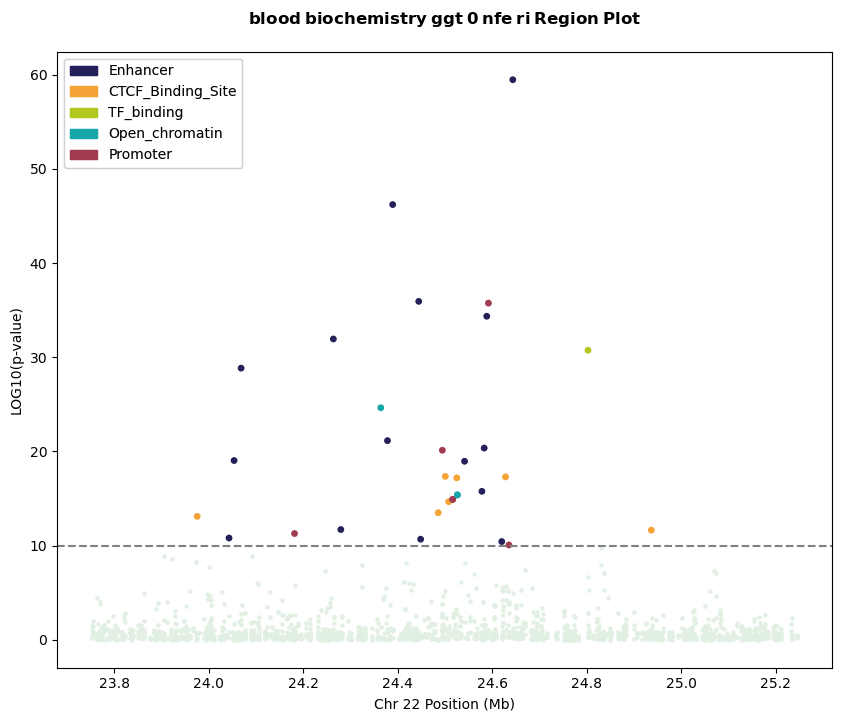

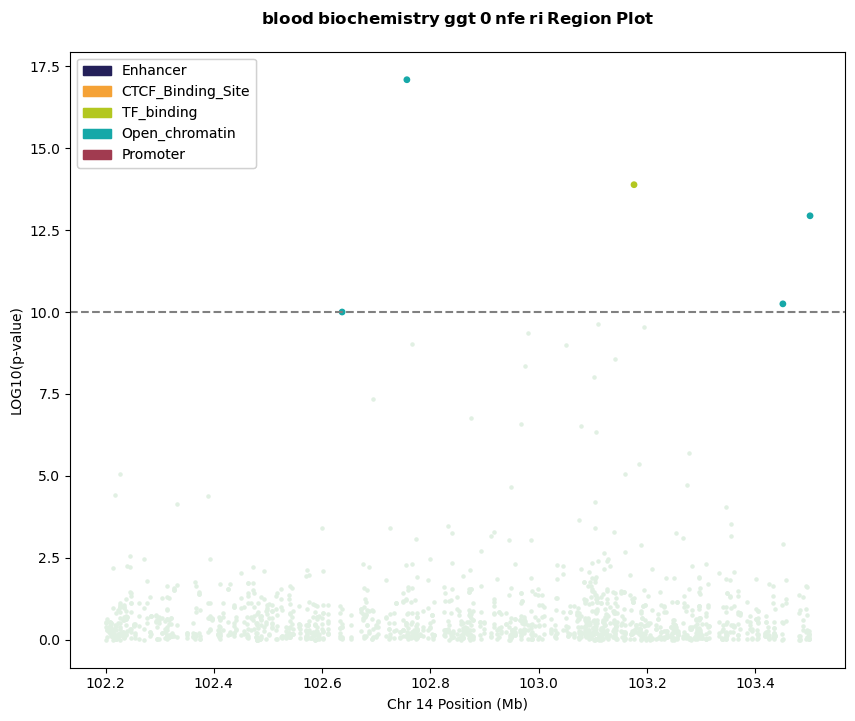

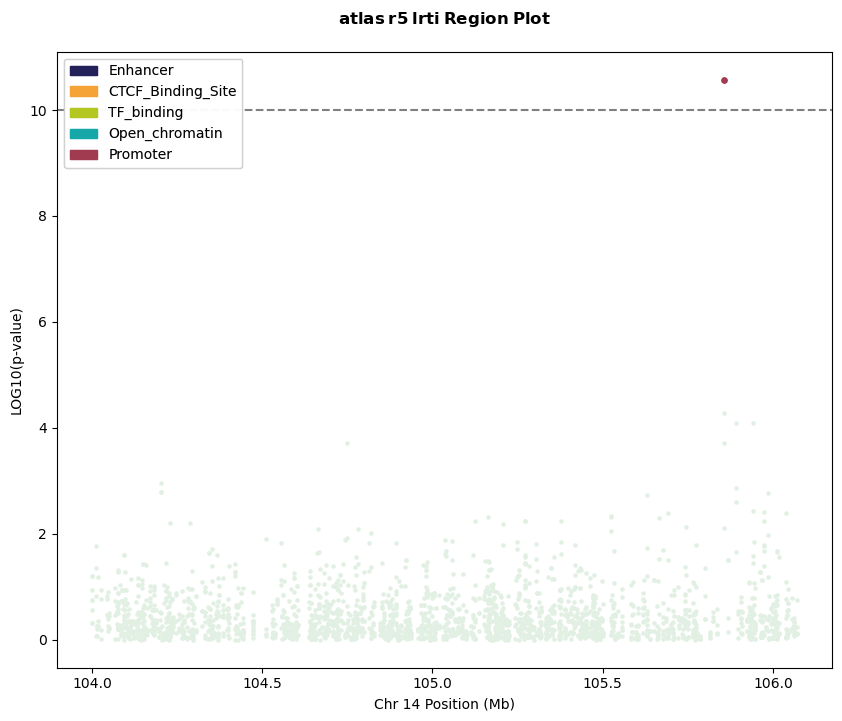

In [38]:
region_plot(['blood_biochemistry_ggt_0_nfe_ri'],[22],10,23.75,25.25)
region_plot(['blood_biochemistry_ggt_0_nfe_ri'],[14],10,102.2,103.5)
region_plot(['atlas_r5_lrti'],[14],10,104,106.1)

In [20]:
def x_co_x(x):
    '''
    Function for chaneing the range of x_coor for chromosome X
    '''
    if x>25085:
        return ((x-29214)/(983869-29214))*(25495-25084)+25084
    else:
        return x

# fix x_coor
sig['x_coor']=sig['x_coor'].apply(x_co_x)

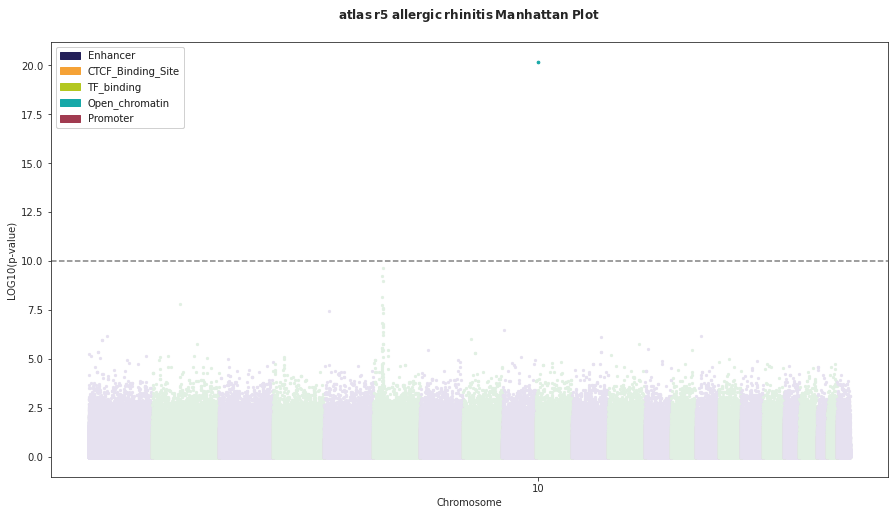

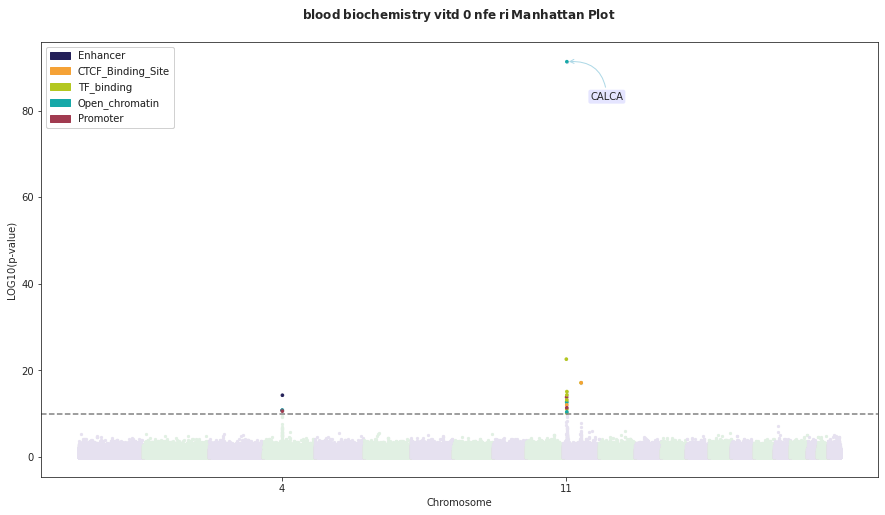

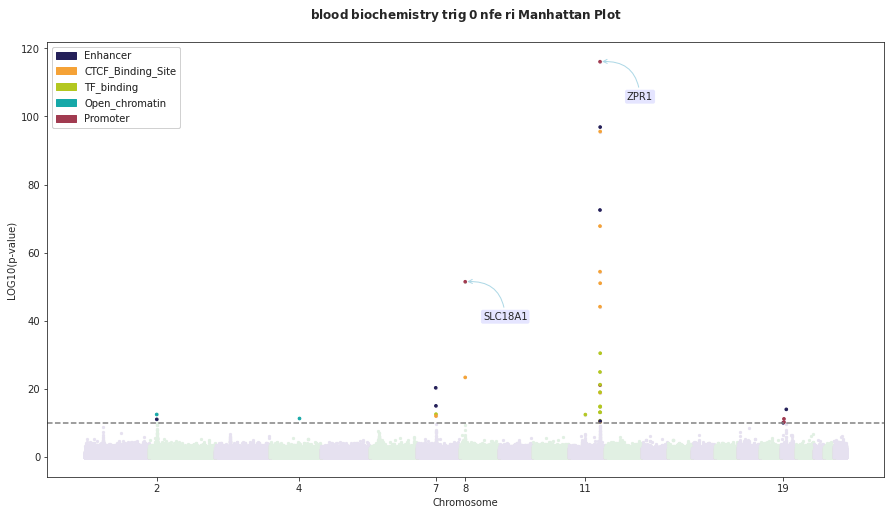

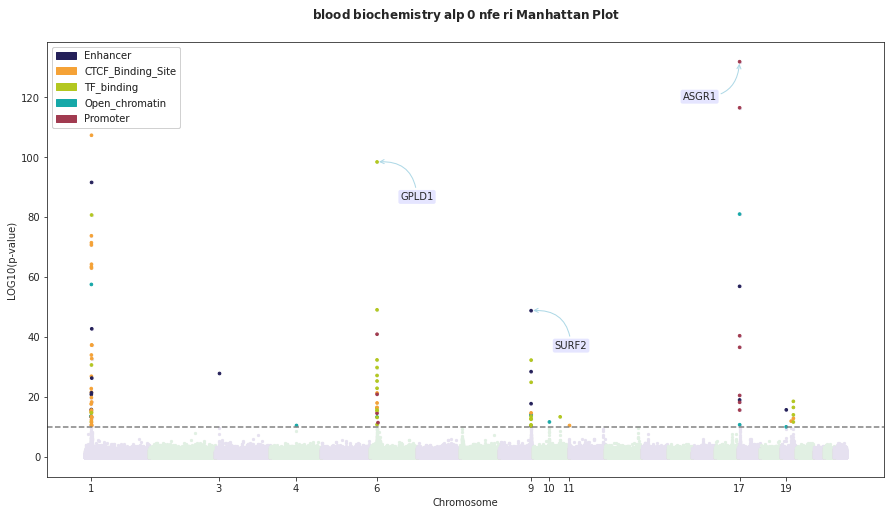

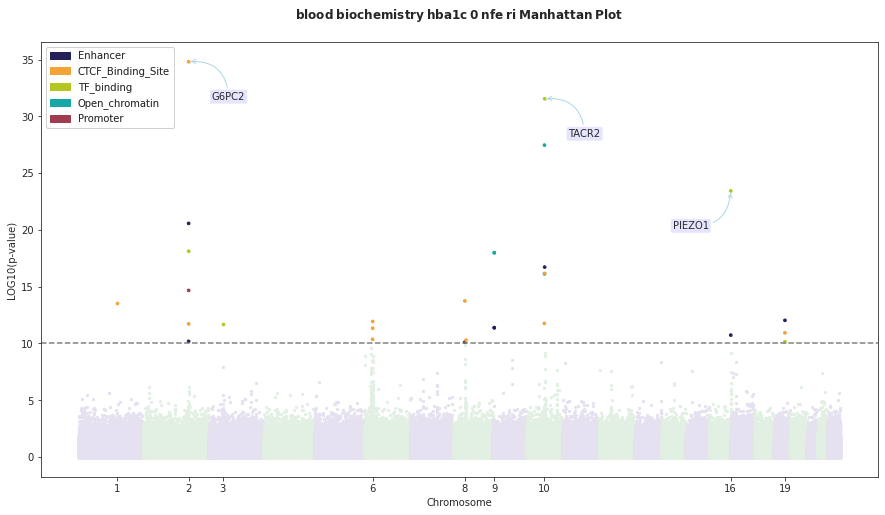

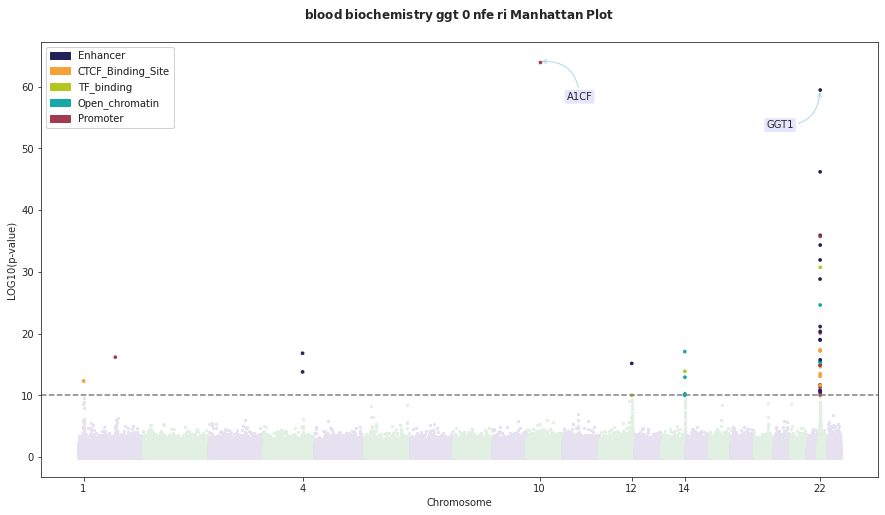

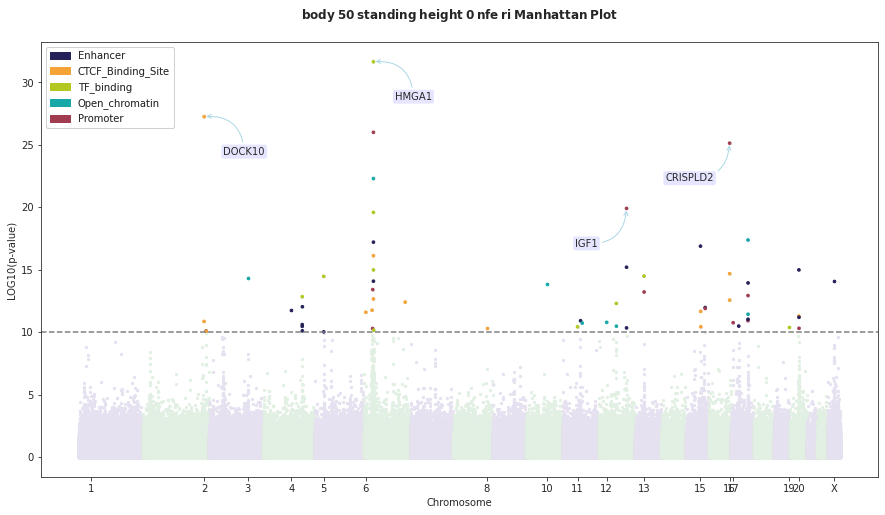

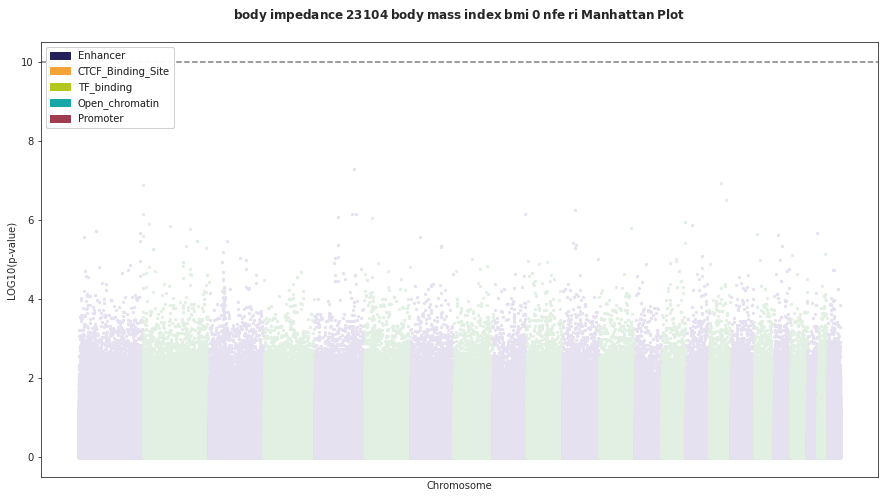

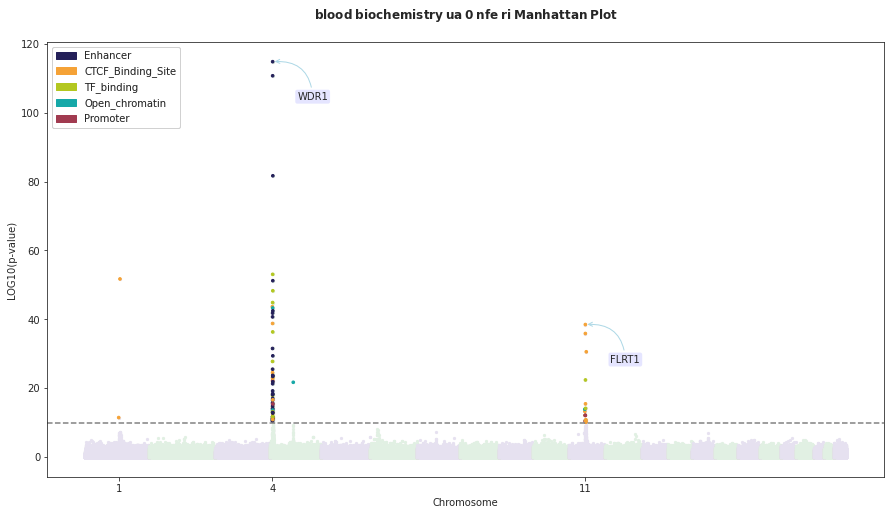

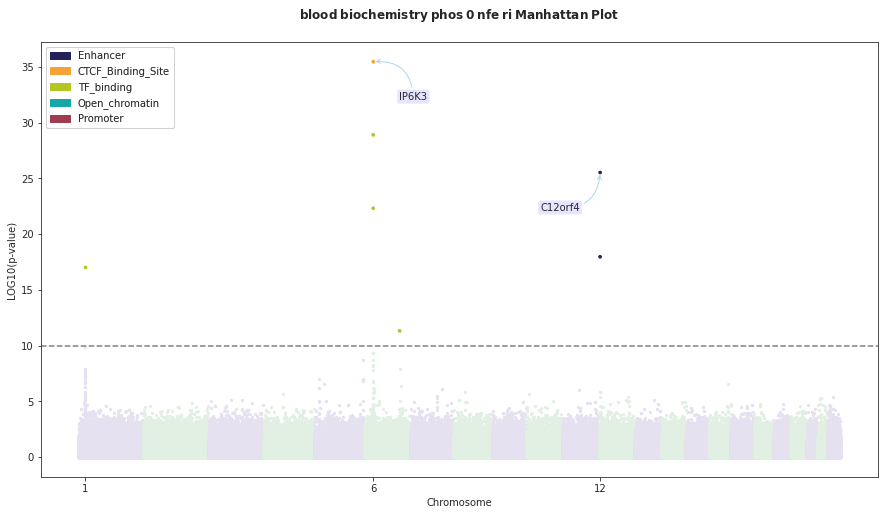

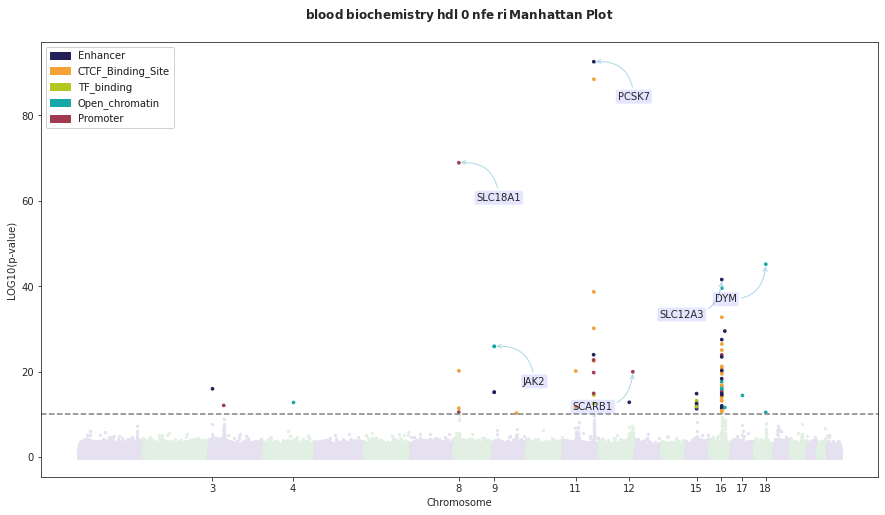

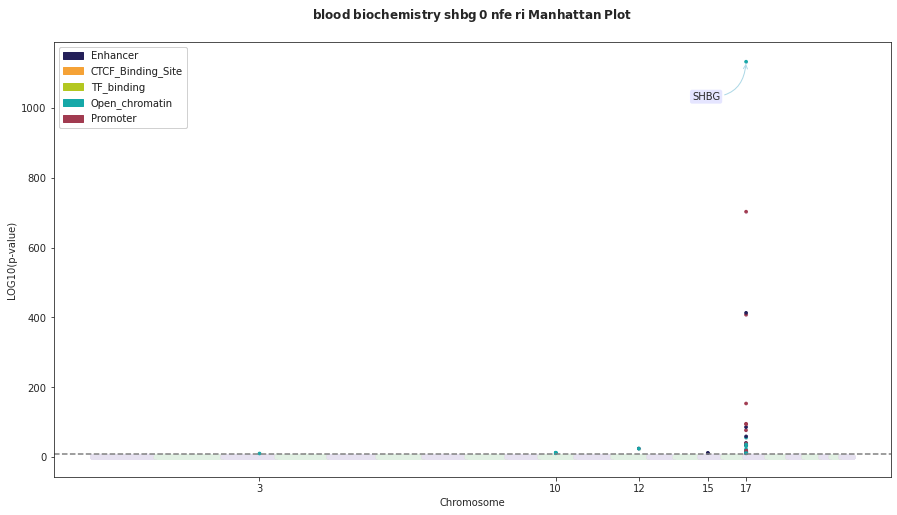

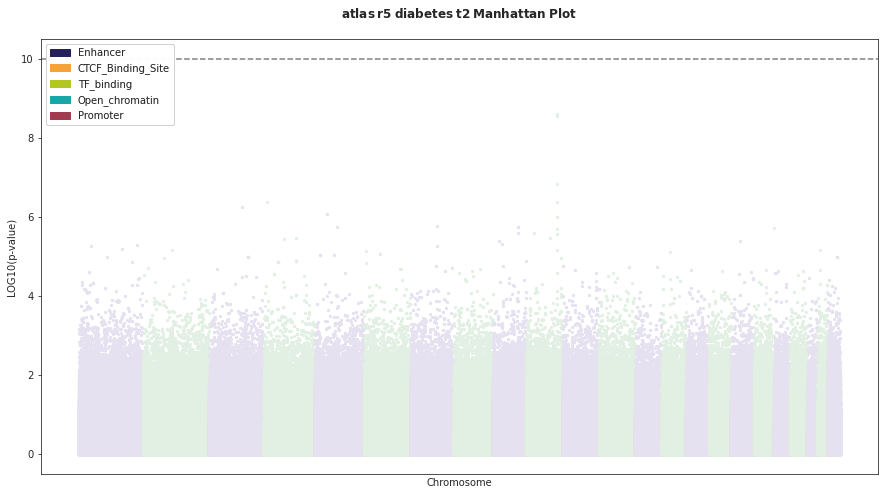

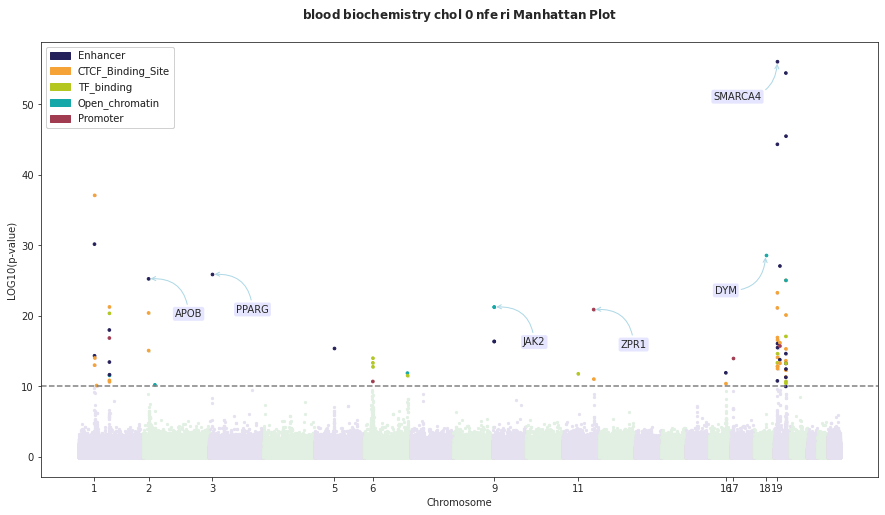

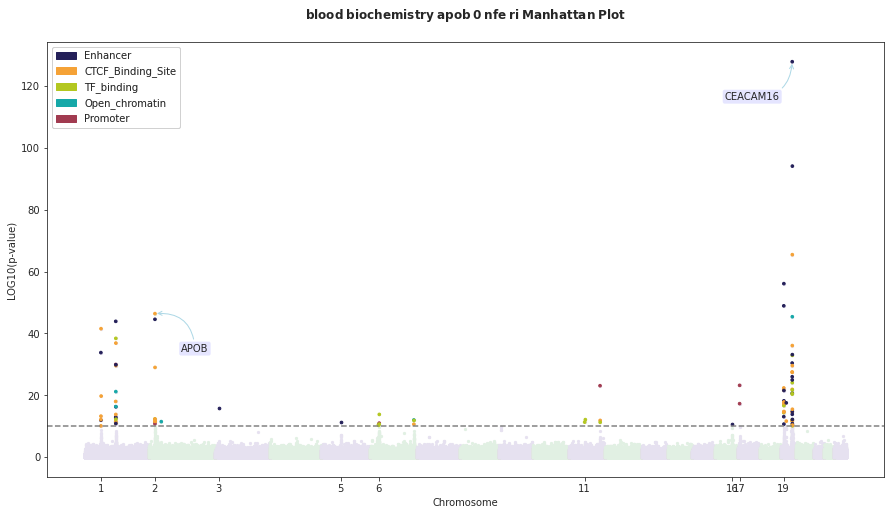

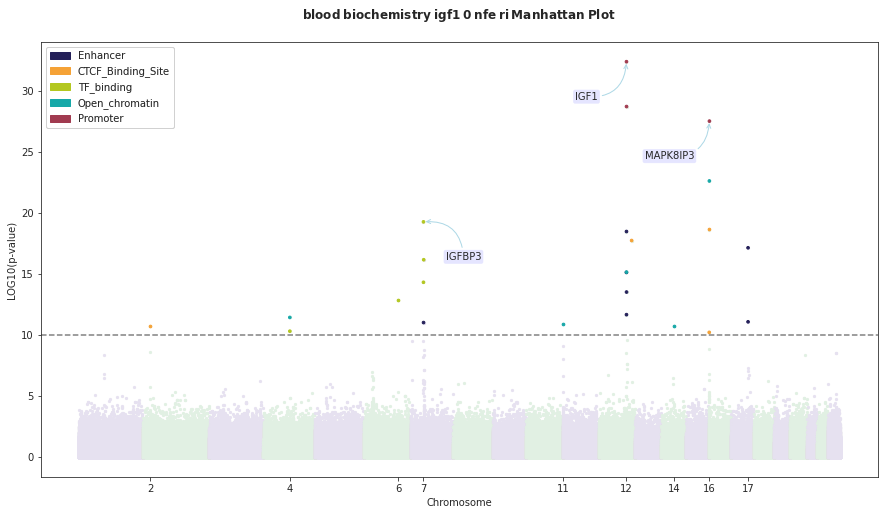

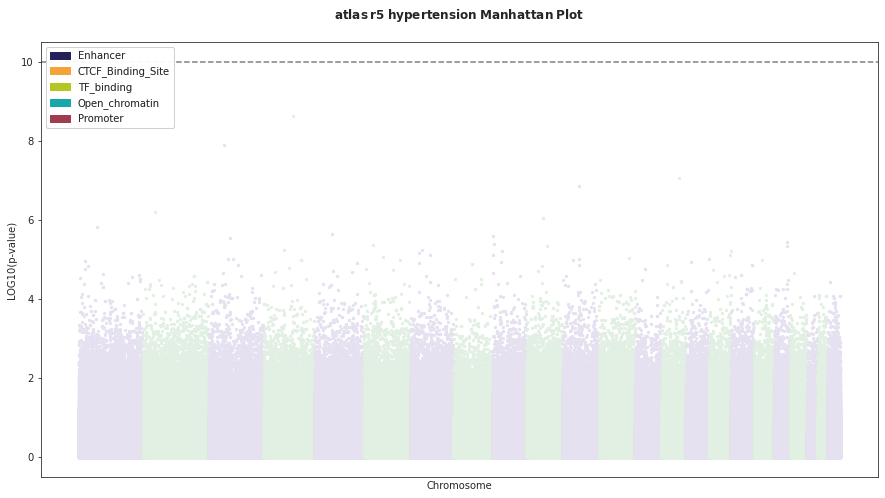

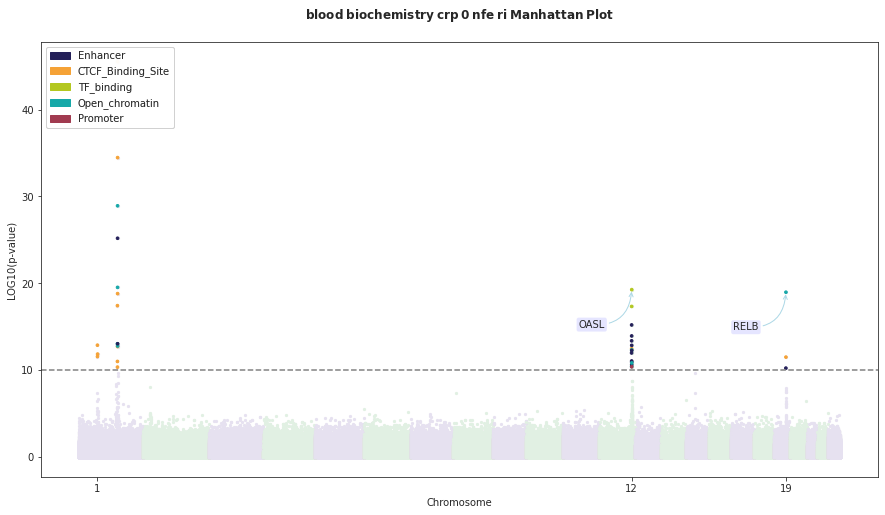

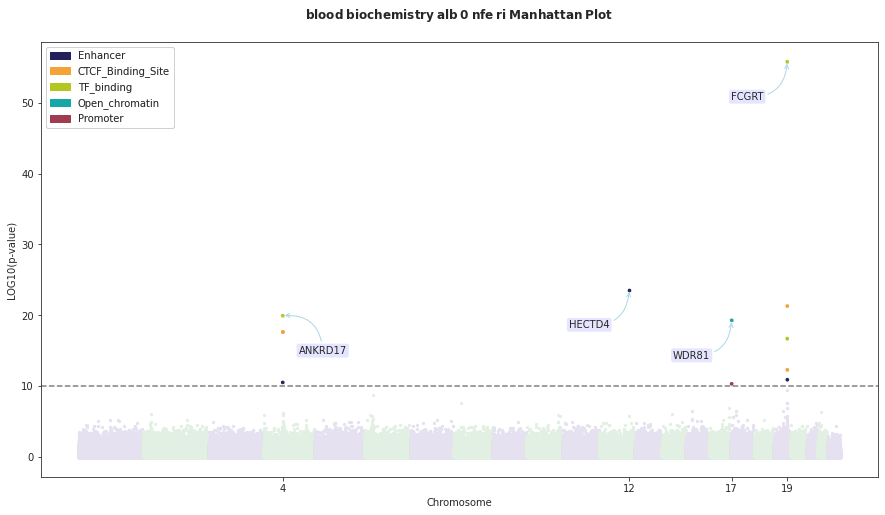

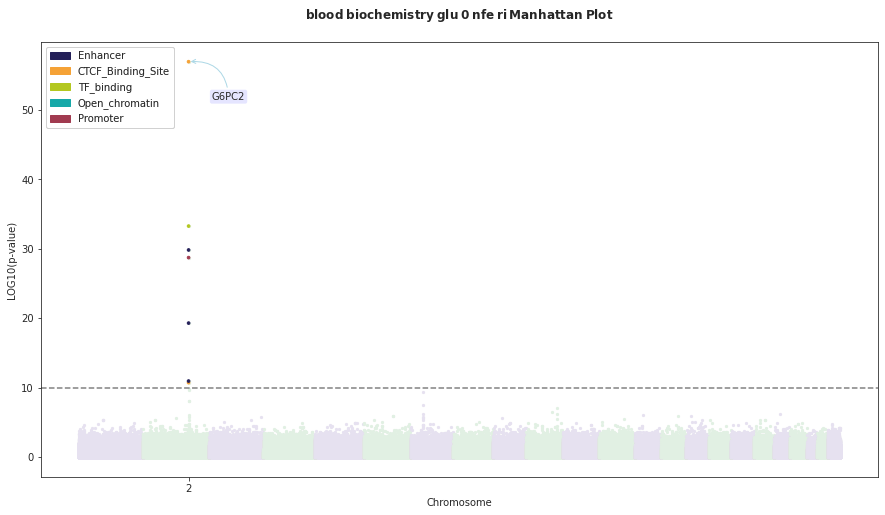

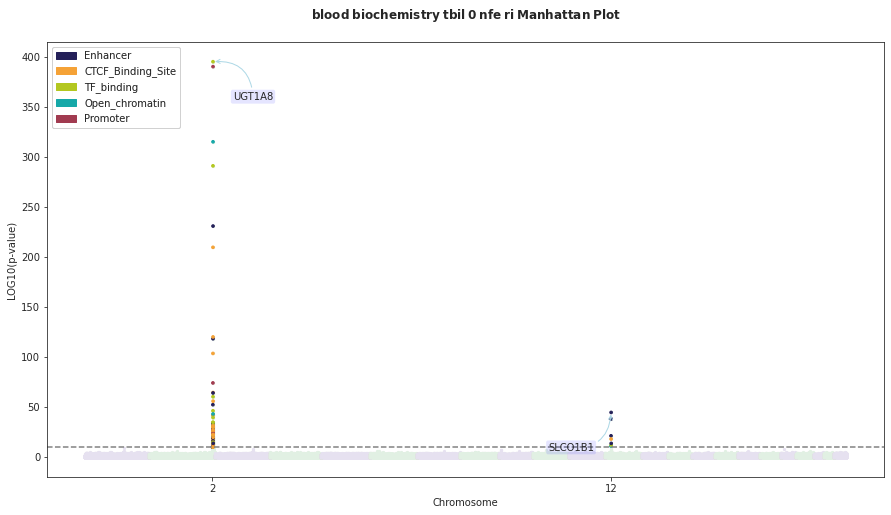

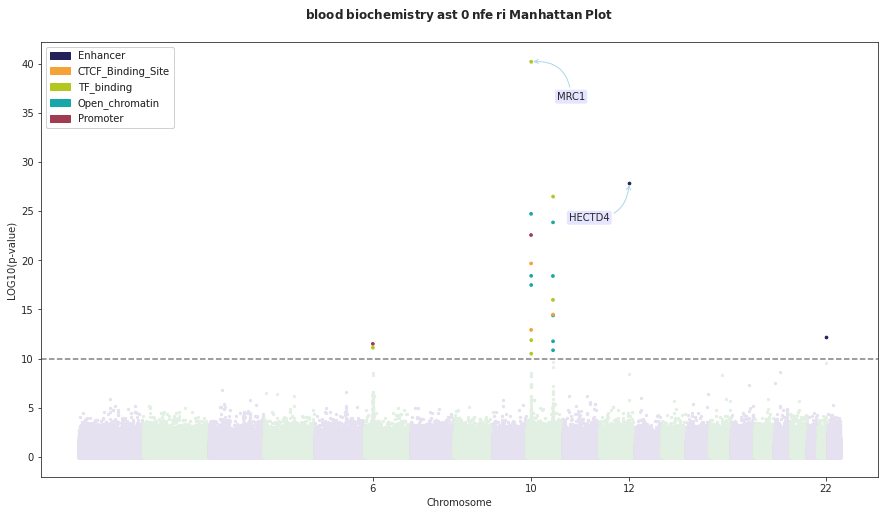

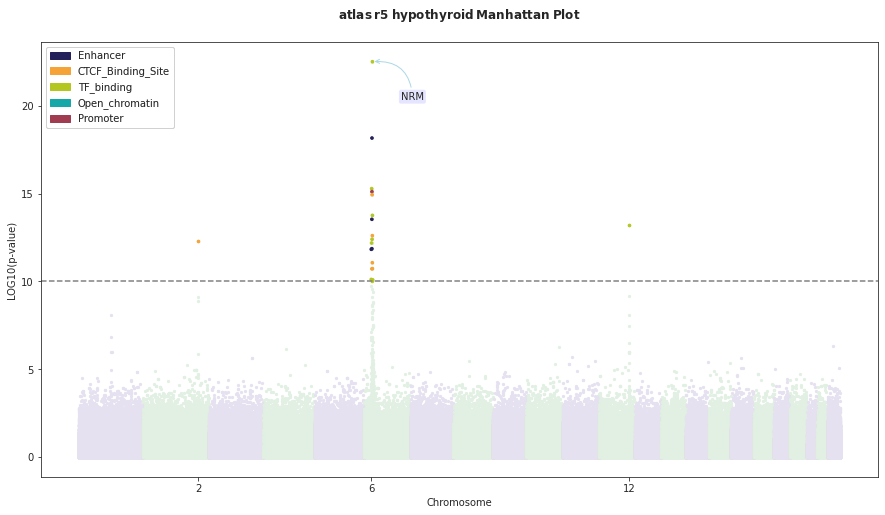

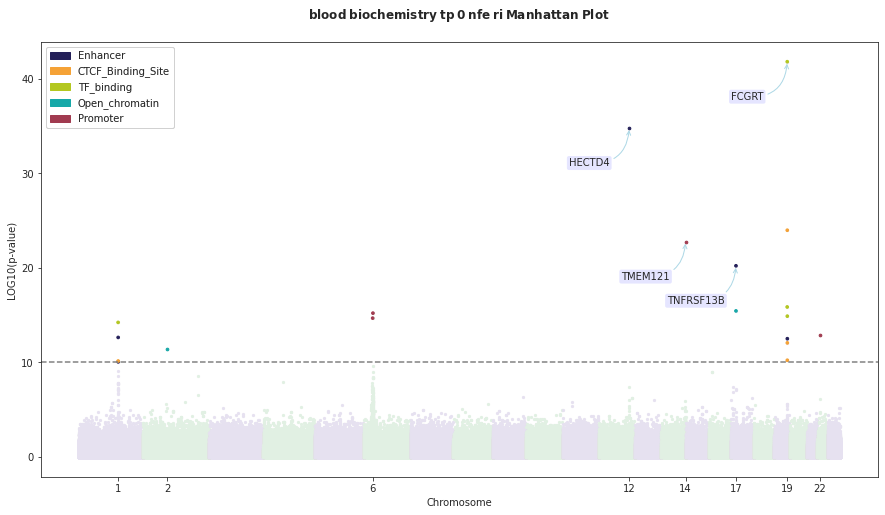

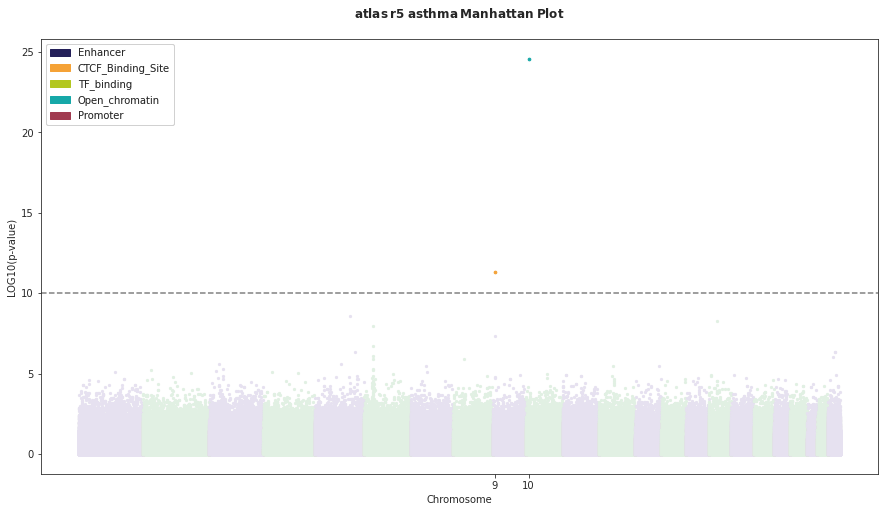

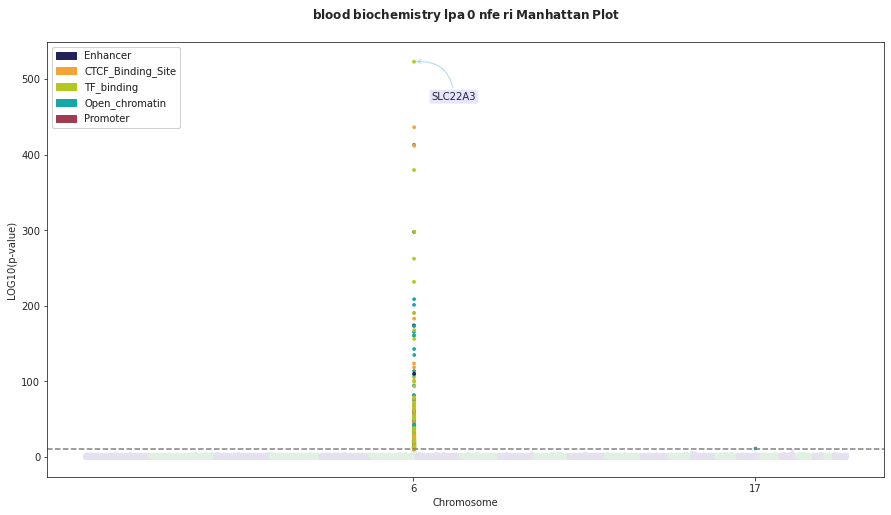

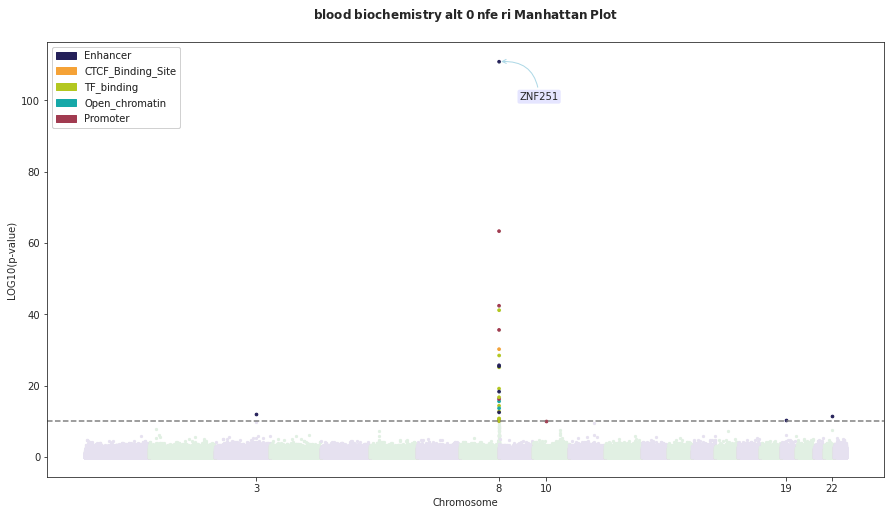

In [25]:
# for plotting manhattan plot

# init chromosomes and get sig log10p>10
chromosomes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,'X']
sig=sig[sig['LOG10P']>10]

sns.set_style("ticks")

# go through phenos that had more than 100 sigificant gwas
for pheno in sig_gwas_pheno['pheno'].unique():
    # init plot for pheno
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # init i for switching color per chrom
    i=0
    
    # get sig of pheno 
    group = sig[sig['pheno']==pheno]
    
    # Read in all point per chrom and plot
    for chrom in chromosomes:
        i=i+1
        gr = r"/home/as028527/Regenie/ann/co_"+str(chrom)+".tsv"
        gr = pd.read_csv(gr, sep="\t")
        gr = gr[gr['pheno']==pheno]
        gr['x_coor']=gr['x_coor'].apply(x_co_x)
        if i%2==0:
            col = '#e1f0e3'
        else:
            col = '#e6e1f0'
        
        # plot all points
        ax.scatter(gr['x_coor'], gr['LOG10P'], c=col, label=pheno, s=5)
       
        # plot sig points
        chrom_df = group[group['CHROM']==chrom]
        ax.scatter(chrom_df['x_coor'], chrom_df['LOG10P'], c=chrom_df['color'], label=pheno, s=7)
    
    # set axis ticks
    chrom_labs = group['CHROM'].unique()
    chrom_ticks= [group[group['CHROM']==chrom]['x_coor'].iloc[0] for chrom in chrom_labs]
    ax.set_xticks(chrom_ticks)
    ax.set_xticklabels(chrom_labs)
    
    # draw significance threshold
    sig_thresh = 10
    ax.axhline(y=sig_thresh, color='gray', linestyle='--')
    
    # set specification for annot location and what to annotate
    if group['LOG10P'].max()>100:
        group_peak = group[group['LOG10P']>=sig_thresh+25]
    elif group['LOG10P'].max()>20:
        group_peak = group[group['LOG10P']>=sig_thresh+8]
    else:
        group_peak = group[group['LOG10P']>=sig_thresh]
    
    group_peak = group_peak.loc[group_peak.groupby('CHROM')['LOG10P'].idxmax()]
    group_peak = group_peak[group_peak['gene_name'].notna()]
    
    for i, row in group_peak.iterrows():
        x=40
        if row['CHROM']!='X':
            if int(row['CHROM'])>11:
                x=-40

        # The nearest gene annots
        ax.annotate( str(row['gene_name']), 
                    xy=(row['x_coor'], row['LOG10P']), xytext=(x,-40),
                    textcoords='offset points', ha='center', va='bottom', 
                    bbox=dict(boxstyle='round,pad=0.2',
                    fc='blue', alpha=0.1), arrowprops=dict(arrowstyle='->', 
                                                           connectionstyle='arc3,rad=0.5',
                                                           color='lightblue'))

        
    # fix length of pheno description 
    if (len(desc[desc['analysis']==pheno])!=0 and
                            desc[desc['analysis']==pheno]['description'] is not None):
        dsc = desc[desc['analysis']==pheno]['description'][0]
        dsc='\n'.join(textwrap.wrap(dsc, width=140))
    else:
        dsc = ''
    
    # Write axis labels and set title with description
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('LOG10(p-value)')
    ax.set_title(r"$\bf{"+pheno.replace('_','\:')+"\:Manhattan\:Plot}$ \n"+dsc)
    
    # add regulatory element legend
    legend_h = [plt.Rectangle((0,0),1,1,color=color) for color in color_dict.values()]
    legend_l = list(color_dict.keys())
    legen = ax.legend(legend_h, legend_l, loc='upper left')
    ax.add_artist(legen)
    
    # save plot
    plt.savefig("path/sigs_"+pheno+"_in_gwas_reg.png", format='png', bbox_inches='tight')
    
    plt.show()

In [150]:
# for j, (pheno, group) in enumerate(sig_gwas_pheno.groupby('pheno')):
#     fig, ax = plt.subplots(1,1,figsize=(15, 8))
    
#     gr = sig[sig['pheno']==pheno]
#     for k, chrom in enumerate(gr['CHROM'].unique()):
#         chrom_df = gr[gr['CHROM']==chrom]
#         if k%2==0:
#             col = '#a7b8a8'
#         else:
#             col = '#b4a7b8'
    
#     ax.scatter(chrom_df['x_coor'], chrom_df['LOG10P'], c=col, label=pheno, s=5)
    
#     chrom_labs = gr['CHROM'].unique()
#     chrom_ticks= [gr[gr['CHROM']==chrom]['x_coor'].iloc[0] for chrom in chrom_labs]
#     ax.set_xticks(chrom_ticks)
#     ax.set_xticklabels(chrom_labs)
    
#     for i, chrom in enumerate(group['CHROM'].unique()):
#         chrom_df = group[group['CHROM']==chrom]
#         ax.scatter(chrom_df['x_coor'], chrom_df['LOG10P'], c=chrom_df['color'], label=pheno, s=5)

    
#     sig_thresh = 10
#     ax.axhline(y=sig_thresh, color='gray', linestyle='--')
#     for i in range(len(chrom_ticks)-1):
#         ax.axvline(x=(chrom_ticks[i]+chrom_ticks[i+1])/2, color='gray', linestyle='-')

#     group_peak = group[group['LOG10P']>=sig_thresh+8]
#     group_peak = group_peak.loc[group_peak.groupby('CHROM')['LOG10P'].idxmax()]
#     for i, row in group_peak.iterrows():
#         if row['CHROM']>11:
#             x=-40
#         else:
#             x=40
#         ax.annotate("Nearest Protein-Coding Gene\n " + row['ensembl_gene_id'], 
#                     xy=(row['x_coor'], row['LOG10P']), xytext=(x,-40),
#                     textcoords='offset points', ha='center', va='bottom', 
#                     bbox=dict(boxstyle='round,pad=0.2',
#                     fc='blue', alpha=0.1), arrowprops=dict(arrowstyle='->', 
#                                                            connectionstyle='arc3,rad=0.5',
#                                                            color='lightblue'))

#     if desc[desc['analysis']==pheno]['description'] is not None:
#         dsc = desc[desc['analysis']==pheno]['description'][0]
#         dsc='\n'.join(textwrap.wrap(dsc, width=140))
#     else:
#         dsc = ''
#     ax.set_xlabel('Chromosome')
#     ax.set_ylabel('LOG10(p-value)')
#     ax.set_title(r"$\bf{"+pheno.replace('_','\:')+"\:Manhattan\:Plot}$ \n"+dsc)
    
#     legend_h = [plt.Rectangle((0,0),1,1,color=color) for color in color_dict.values()]
#     legend_l = list(color_dict.keys())
#     if j==3:
#         legen = ax.legend(legend_h, legend_l, loc='upper right')
#     else:
#         legen = ax.legend(legend_h, legend_l, loc='upper left')
#     ax.add_artist(legen)
    
#     plt.savefig("./path/sigs_"+pheno+"_in_gwas_reg.png", format='png', bbox_inches='tight')
    
#     plt.show()

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(22, 10))
# for i, (pheno, group) in enumerate(sig_gwas_pheno[sig_gwas_pheno['LOG10P']<400].groupby('pheno')):
#     ax.scatter(group['pos'], group['LOG10P'], c=group['color'], label=pheno,)
# ax.set_xlabel('Position - Mid-Point (all chromosomes)')
# ax.set_ylabel('log10(p-value)')
# ax.legend()

# legend_h = [plt.Rectangle((0,0),1,1,color=color) for color in color_dict.values()]
# legend_l = list(color_dict.keys())
# legen = ax.legend(legend_h, legend_l, loc='upper right')
# ax.add_artist(legen)

# # scatter_leg = ax.legend(*scatter.legend_elements())


# plt.savefig("./path/less_sig_common_pheno_in_gwas_regions.png",
#                 format='png', bbox_inches='tight')
# plt.show() 

In [ ]:
# count of phenos in chromosome based gwas mapping
chro_hit['regenei_pheno'].value_counts()